# Predcition of Hospital Admission Related to Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sore throat.

In [19]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [20]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [21]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [22]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [23]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'throat_date_'+str(i), 'throat_ab_date_'+str(i), 'throat_ab_type_'+str(i),
                   'incdt_throat_date_'+str(i), 'admitted_throat_date_'+str(i), 'sgss_gp_cov_throat_date_'+str(i)]]
    
    #drop rows with no throat reord
    datum = datum[datum['throat_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with throat_i
    datum = datum[datum['sgss_gp_cov_throat_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'throat_date_'+str(i): 'throat_date', 'throat_ab_date_'+str(i): 'throat_ab_date', 
                           'throat_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_throat_date_'+str(i): 'incdt_throat_date', 'incdt_throat_type_'+str(i): 'incdt_throat_type',
                           'admitted_throat_date_'+str(i): 'admitted_throat_date',
                           'sgss_gp_cov_throat_date_'+str(i): 'sgss_gp_cov_throat_date'},
                inplace=True)
    
    return datum

In [24]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_throat_admitted', 'duration_throat_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [25]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [26]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [27]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [28]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [29]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [30]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [31]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [32]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [33]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [34]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [35]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [36]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

data.shape

(200000, 224)

In [37]:
# save model outputs
a = open("../output/hospitalisation_prediction_throat/data_throat_record_cph_throat.txt", "w")
a.write("")
a.writelines(['data_throat_1 #with a record, #with no record: %.0f' % (data['throat_date_1'].notna().sum()), ', %.0f' % (data['throat_date_1'].isna().sum()),
              '\ndata_throat_2 #with a record, #with no record: %.0f' % (data['throat_date_2'].notna().sum()), ', %.0f' % (data['throat_date_2'].isna().sum()),
              '\ndata_throat_3 #with a record, #with no record: %.0f' % (data['throat_date_3'].notna().sum()), ', %.0f' % (data['throat_date_3'].isna().sum()),
              '\ndata_throat_4 #with a record, #with no record: %.0f' % (data['throat_date_4'].notna().sum()), ', %.0f' % (data['throat_date_4'].isna().sum()),
              '\ndata_throat_5 #with a record, #with no record: %.0f' % (data['throat_date_5'].notna().sum()), ', %.0f' % (data['throat_date_5'].isna().sum()),
              '\ndata_throat_6 #with a record, #with no record: %.0f' % (data['throat_date_6'].notna().sum()), ', %.0f' % (data['throat_date_6'].isna().sum()),
              '\ndata_throat_7 #with a record, #with no record: %.0f' % (data['throat_date_7'].notna().sum()), ', %.0f' % (data['throat_date_7'].isna().sum()),
              '\ndata_throat_8 #with a record, #with no record: %.0f' % (data['throat_date_8'].notna().sum()), ', %.0f' % (data['throat_date_8'].isna().sum()),
              '\ndata_throat_9 #with a record, #with no record: %.0f' % (data['throat_date_9'].notna().sum()), ', %.0f' % (data['throat_date_9'].isna().sum()),
              '\ndata_throat_10 #with a record, #with no record: %.0f' % (data['throat_date_10'].notna().sum()), ', %.0f' % (data['throat_date_10'].isna().sum()),
              '\ndata_throat_11 #with a record, #with no record: %.0f' % (data['throat_date_11'].notna().sum()), ', %.0f' % (data['throat_date_11'].isna().sum()),
              '\ndata_throat_12 #with a record, #with no record: %.0f' % (data['throat_date_12'].notna().sum()), ', %.0f' % (data['throat_date_12'].isna().sum()),
              '\ndata_throat_13 #with a record, #with no record: %.0f' % (data['throat_date_13'].notna().sum()), ', %.0f' % (data['throat_date_13'].isna().sum()),
              '\ndata_throat_14 #with a record, #with no record: %.0f' % (data['throat_date_14'].notna().sum()), ', %.0f' % (data['throat_date_14'].isna().sum()),
              '\ndata_throat_15 #with a record, #with no record: %.0f' % (data['throat_date_15'].notna().sum()), ', %.0f' % (data['throat_date_15'].isna().sum()),
              '\ndata_throat_16 #with a record, #with no record: %.0f' % (data['throat_date_16'].notna().sum()), ', %.0f' % (data['throat_date_16'].isna().sum()),
              '\ndata_throat_17 #with a record, #with no record: %.0f' % (data['throat_date_17'].notna().sum()), ', %.0f' % (data['throat_date_17'].isna().sum()),
              '\ndata_throat_18 #with a record, #with no record: %.0f' % (data['throat_date_18'].notna().sum()), ', %.0f' % (data['throat_date_18'].isna().sum()),
              '\ndata_throat_19 #with a record, #with no record: %.0f' % (data['throat_date_19'].notna().sum()), ', %.0f' % (data['throat_date_19'].isna().sum()),
              '\ndata_throat_20 #with a record, #with no record: %.0f' % (data['throat_date_20'].notna().sum()), ', %.0f' % (data['throat_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [38]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     37052
0.0     36911
2.0     33035
3.0     24833
4.0     14915
6.0     12364
7.0     10094
5.0      8459
8.0      7927
9.0      5822
10.0     3243
11.0     1835
12.0     1325
13.0      859
14.0      533
15.0      392
16.0      206
17.0      108
18.0       56
19.0       20
20.0       10
24.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [39]:
#read 12 throats and concatenate them 
data_throat_1 = proc_infec_data(data,1)
data_throat_2 = proc_infec_data(data,2)
data_throat_3 = proc_infec_data(data,3)
data_throat_4 = proc_infec_data(data,4)
data_throat_5 = proc_infec_data(data,5)
data_throat_6 = proc_infec_data(data,6)
data_throat_7 = proc_infec_data(data,7)
data_throat_8 = proc_infec_data(data,8)
data_throat_9 = proc_infec_data(data,9)
data_throat_10 = proc_infec_data(data,10)
data_throat_11 = proc_infec_data(data,11)
data_throat_12 = proc_infec_data(data,12)

data_throat = pd.concat([data_throat_1, data_throat_2, data_throat_3, data_throat_4, data_throat_5, data_throat_6, data_throat_7, data_throat_8, data_throat_9, data_throat_10, data_throat_11, data_throat_12])
data_throat.reset_index(inplace=True, drop=True)
data_throat.shape

(215735, 20)

### 2-2- add season, event, and duration variables
#### season

In [40]:
# convert data types
data_throat['throat_date'] = data_throat['throat_date'].astype('datetime64[ns]')
data_throat['admitted_throat_date'] = data_throat['admitted_throat_date'].astype('datetime64[ns]')
data_throat.died_date = data_throat.died_date.astype('datetime64[ns]')
data_throat.deregistered_date = data_throat.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_throat['date'] = data_throat['throat_date'] #gp_cons_throat
data_throat['date'] = data_throat['date'].dt.strftime('%Y-%m')
print(f'min date: {data_throat.date.min()}')
print(f'max date: {data_throat.date.max()}')
print(f'length of data_throat: {len(data_throat)}')

min date: 2019-01
max date: 2022-11
length of data_throat: 215735


In [41]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_throat with today's date in year and month
data_throat = data_throat[data_throat['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_throat = data_throat[data_throat['date'] != last_1_month_date_y_m]
data_throat = data_throat[data_throat['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of throat records
data_throat['season'] = np.nan
data_throat['date_month'] = pd.DatetimeIndex(data_throat['date']).month

conditions = [
    (data_throat['date_month'] >= 3) & (data_throat['date_month'] <= 5),
    (data_throat['date_month'] >= 6) & (data_throat['date_month'] <= 8),
    (data_throat['date_month'] >= 9) & (data_throat['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_throat['season'] = np.select(conditions, choices, default='winter')

print(data_throat['season'].value_counts())
print(f'\nmin date: {data_throat.date.min()}')
print(f'max date: {data_throat.date.max()}')
print(f'length: {len(data_throat)}')

spring    56133
summer    56113
winter    49978
autumn    41481
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 203705


In [42]:
# data_throat = data_throat[data_throat['date'] <= '2019-12']
# data_throat = data_throat[(data_throat['date'] >= '2020-03') & (data_throat['date']<= '2021-03')]
# data_throat = data_throat[data_throat['date'] >= '2021-04']
# print(f'min date: {data_throat.date.min()}')
# print(f'max date: {data_throat.date.max()}')

#### event and duration

In [43]:
#scenario 1
#not hosped (nothing happened)
#data_throat = data_throat[data_throat['admitted_throat_date'].notnull()]
data_throat.loc[data_throat['admitted_throat_date'].isnull(), 'event_throat_admitted'] = 0
data_throat['event_throat_admitted'].value_counts()

0.0    142753
Name: event_throat_admitted, dtype: int64

In [44]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days
data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days #gp_cons_throat
data_throat.loc[((data_throat['delta_throat_admitted'] >= 0) & (data_throat['delta_throat_admitted'] <= 30)), 'event_throat_admitted'] = 1
# data_throat['event_throat_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before throat consultation, i.e. negative value for delta_throat_admitted
data_throat = data_throat[~(data_throat['delta_throat_admitted'] < 0)]
data_throat['delta_throat_admitted'].value_counts()

11.0      62
62.0      59
54.0      57
36.0      57
24.0      57
          ..
1372.0     1
1327.0     1
1364.0     1
1362.0     1
1304.0     1
Name: delta_throat_admitted, Length: 1386, dtype: int64

In [45]:
#scenario 3
#censor died patients
data_throat['delta_admitted_died'] = (data_throat['died_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_throat.loc[data_throat['delta_admitted_died'] >= 0, 'event_throat_admitted'] = 0
data_throat.loc[((data_throat['delta_admitted_died'] >= 0) & (data_throat['delta_admitted_died'] <= 30)), 'event_throat_admitted'] = 0
# data_throat['event_throat_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_throat['delta_admitted_deregistered'] = (data_throat['deregistered_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_throat.loc[data_throat['delta_admitted_deregistered'] >= 0, 'event_throat_admitted'] = 0
data_throat.loc[((data_throat['delta_admitted_deregistered'] > 0) & (data_throat['delta_admitted_deregistered'] <= 30)), 'event_throat_admitted'] = 0
# data_throat['event_throat_admitted'].value_counts()

#agg scenario 3s
data_throat['delta_admitted_died_deregistered'] = data_throat['delta_admitted_deregistered'].combine_first(data_throat['delta_admitted_died'])
data_throat.loc[data_throat['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_throat['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

171714

In [46]:
#scenario 1
#any other patients (nothing happened)
data_throat['event_throat_admitted'] = data_throat['event_throat_admitted'].replace(np.NaN, 0)
data_throat['event_throat_admitted'].value_counts()

0.0    173507
1.0      1397
Name: event_throat_admitted, dtype: int64

In [47]:
#assign values for duration column
data_throat['duration_throat_admitted'] = data_throat['delta_throat_admitted'].combine_first(data_throat['delta_admitted_died_deregistered'])
data_throat['duration_throat_admitted'] = data_throat['duration_throat_admitted'].replace(np.NaN, 30)
data_throat.loc[(data_throat['duration_throat_admitted'] > 30), 'duration_throat_admitted'] = 30
data_throat['duration_throat_admitted'].value_counts()

30.0    173553
11.0        62
24.0        57
12.0        54
17.0        53
16.0        52
20.0        51
7.0         50
22.0        49
5.0         48
4.0         47
26.0        47
2.0         45
21.0        45
1.0         45
8.0         45
19.0        44
18.0        44
3.0         44
29.0        43
9.0         43
28.0        43
14.0        41
6.0         41
23.0        40
13.0        39
0.0         39
10.0        38
25.0        35
15.0        34
27.0        33
Name: duration_throat_admitted, dtype: int64

In [48]:
# give value 1 to event_throat_admitted if duration_throat_admitted is greater or equal to 0 and less than 30
data_throat.loc[((data_throat['duration_throat_admitted'] >= 0) & (data_throat['duration_throat_admitted'] < 30)), 'event_throat_admitted'] = 1
data_throat['event_throat_admitted'].value_counts()

0.0    173505
1.0      1399
Name: event_throat_admitted, dtype: int64

In [49]:
#drop any rows with value 0 in duration column
data_throat = data_throat[~(data_throat['duration_throat_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_throat.loc[((data_throat['delta_throat_admitted'] > 0) & (data_throat['delta_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

In [50]:
# data_throat[data_throat['duration_throat_admitted']==0][['delta_throat_admitted', 'throat_date', 'gp_cons_throat', 'admitted_throat_date', 'delta_throat_admitted', 'delta_admitted_died_deregistered', 'event_throat_admitted', 'duration_throat_admitted']]
# data_throat.loc[151:200, ['event_throat_admitted', 'duration_throat_admitted']]
# data_throat.loc[201:250, ['event_throat_admitted', 'duration_throat_admitted']].sort_values(by=['duration_throat_admitted'])
data_throat[['event_throat_admitted', 'duration_throat_admitted']].sort_values(by=['duration_throat_admitted'])

,event_throat_admitted,duration_throat_admitted
83441,1.0,1.0
25521,1.0,1.0
21319,1.0,1.0
153641,1.0,1.0
53347,1.0,1.0
...,...,...
72195,0.0,30.0
72196,0.0,30.0
72197,0.0,30.0
72188,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [51]:
# prep before plot
data_throat['age'][data_throat['age'] < 0] = np.nan
data_throat = data_throat[data_throat['age_cat'] != '0-4']
data_throat = data_throat[data_throat['age_cat'] != '5-14']
# drop anybody with age less than 18
data_throat = data_throat[~(data_throat['age'] < 18)]  
print(f'Min age: {data_throat.age.min()}')

## remove died cases
#data_throat.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_throat['bmi'][data_throat['bmi'] < 10] = 0
# replace 0s with nans
data_throat['bmi'] = data_throat['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_throat['antibacterial_brit'][data_throat['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [52]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_throat = data_throat.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_throat = data_throat.replace({"smoking_status": dict_smoking})

In [53]:
if ('region' in data_throat.columns) and (data_throat['region'].isnull().sum() > 0):
    # drop region value missing
    # data_throat['region_imp'] = data_throat['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_throat.region.isnull().sum()}')
    data_throat = data_throat[data_throat['region'].notna()]

print(f'Cound of missing values in variable region: {data_throat.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_throat.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21016
Yorkshire and The Humber    10766
North East                  10762
South West                  10672
East Midlands               10657
South East                  10610
East                        10605
West Midlands               10555
North West                  10452
Name: region, dtype: int64


In [54]:
if ('antibacterial_brit' in data_throat.columns) and (data_throat['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_throat.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_throat.antibacterial_brit.mean():.3f}')
    data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].fillna(0)
    # data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_throat.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_throat.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.249

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.249


In [55]:
if ('ethnicity' in data_throat.columns) and (data_throat['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_throat.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_throat.ethnicity.value_counts()}')
    # data_throat['ethnicity'] = data_throat['ethnicity'].astype(str)
    data_throat['ethnicity'] = data_throat['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_throat.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_throat.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26382
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63675
5.0     8163
3.0     7875
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63675
0.0    26382
5.0     8163
3.0     7875
Name: ethnicity, dtype: int64


In [56]:
if ('smoking_status' in data_throat.columns) and (data_throat['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_throat.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_throat.smoking_status.value_counts()}')
    # data_throat['smoking_status'] = data_throat['smoking_status'].astype(str)
    data_throat['smoking_status'] = data_throat['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_throat.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_throat.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 44064
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41469
3.0    13635
2.0     6927
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    44064
1.0    41469
3.0    13635
2.0     6927
Name: smoking_status, dtype: int64


In [57]:
if ('imd' in data_throat.columns) and (data_throat['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_throat.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_throat.imd.value_counts()}')
    # data_throat['imd'] = data_throat['imd'].astype(str)
    data_throat['imd'] = data_throat['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_throat.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_throat.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
4    20468
1    20265
5    20113
3    20029
2    19924
0     5296
Name: imd, dtype: int64


In [58]:
data_throat['bmi_cat'] = 5
col_bmi_cat = data_throat.columns.get_loc('bmi_cat')

col_sex = data_throat.columns.get_loc('sex')
col_age = data_throat.columns.get_loc('age')
col_bmi = data_throat.columns.get_loc('bmi')

for idx, x in enumerate(data_throat['bmi_cat']):
    if data_throat.iat[idx, col_bmi] >= 30:
        data_throat.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_throat.iat[idx, col_bmi] >= 25) and (data_throat.iat[idx, col_bmi] < 30):
        data_throat.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_throat.iat[idx, col_bmi] >= 18.5) and (data_throat.iat[idx, col_bmi] < 25):
        data_throat.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_throat.iat[idx, col_bmi] < 18.5:
        data_throat.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_throat['bmi_cat'].value_counts()

1    54843
5    26892
2    11951
3     8793
4     3616
Name: bmi_cat, dtype: int64

In [59]:
if ('bmi_cat' in data_throat.columns) and (data_throat['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_throat.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_throat.bmi_cat.value_counts()}')
    # data_throat['bmi_cat'] = data_throat['bmi_cat'].astype(str)
    data_throat['bmi_cat'] = data_throat['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_throat.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_throat.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    54843
5    26892
2    11951
3     8793
4     3616
Name: bmi_cat, dtype: int64


In [60]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_throat.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_throat['ab_type_cat'] = np.where(data_throat['ab_type'].isin(ab_series[mask].index),'other',data_throat['ab_type'])

#assign no to non ab users
data_throat.loc[data_throat['throat_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_throat['ab_type_cat'] = data_throat['ab_type_cat'].fillna(0)
data_throat['ab_type_cat'].value_counts()

no             95481
0               8456
other           1295
Amoxicillin      659
Doxycycline      204
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [61]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [62]:
# reoplace values of dictionaries with existing ones
data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"ethnicity": dict_ethnicity})
data_throat = data_throat.replace({"smoking_status": dict_smoking})
data_throat = data_throat.replace({"imd": dict_imd})
data_throat = data_throat.replace({"bmi_cat": dict_bmi})
data_throat = data_throat.replace({"flu_vaccine": dict_flu})
data_throat = data_throat.replace({"region": dict_region})
data_throat = data_throat.replace({"age_cat": dict_age})
data_throat = data_throat.replace({"ab_type_cat": dict_ab_type})
data_throat['ab_type_cat'].value_counts()

no             95481
other           9751
Amoxicillin      659
Doxycycline      204
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [63]:
# categorising
data_throat['CCI_cat'] = pd.cut(data_throat['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_throat['CCI_cat'].value_counts()

low          37628
medium       20790
very_low     19497
very_high    17188
high         10992
Name: CCI_cat, dtype: int64

In [64]:
# assign max value to outliers (beyond 95 percentile)
data_throat['antibacterial_brit'].clip(0, data_throat['antibacterial_brit'].quantile(0.95), inplace=True)
data_throat['antibacterial_brit'].max()

data_throat['antibacterial_brit_cat'] = pd.cut(data_throat['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_throat['antibacterial_brit_cat'].value_counts()

low       61472
high      26580
medium    18043
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

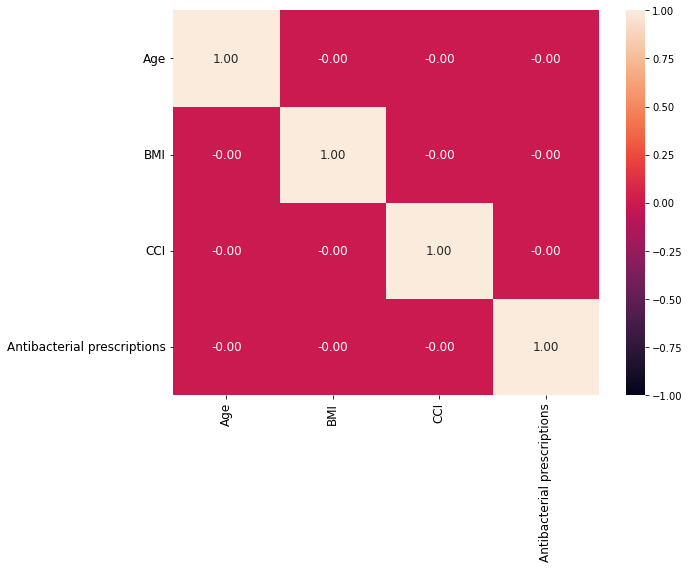

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_throat[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/corr_throat.jpg')
plt.show()

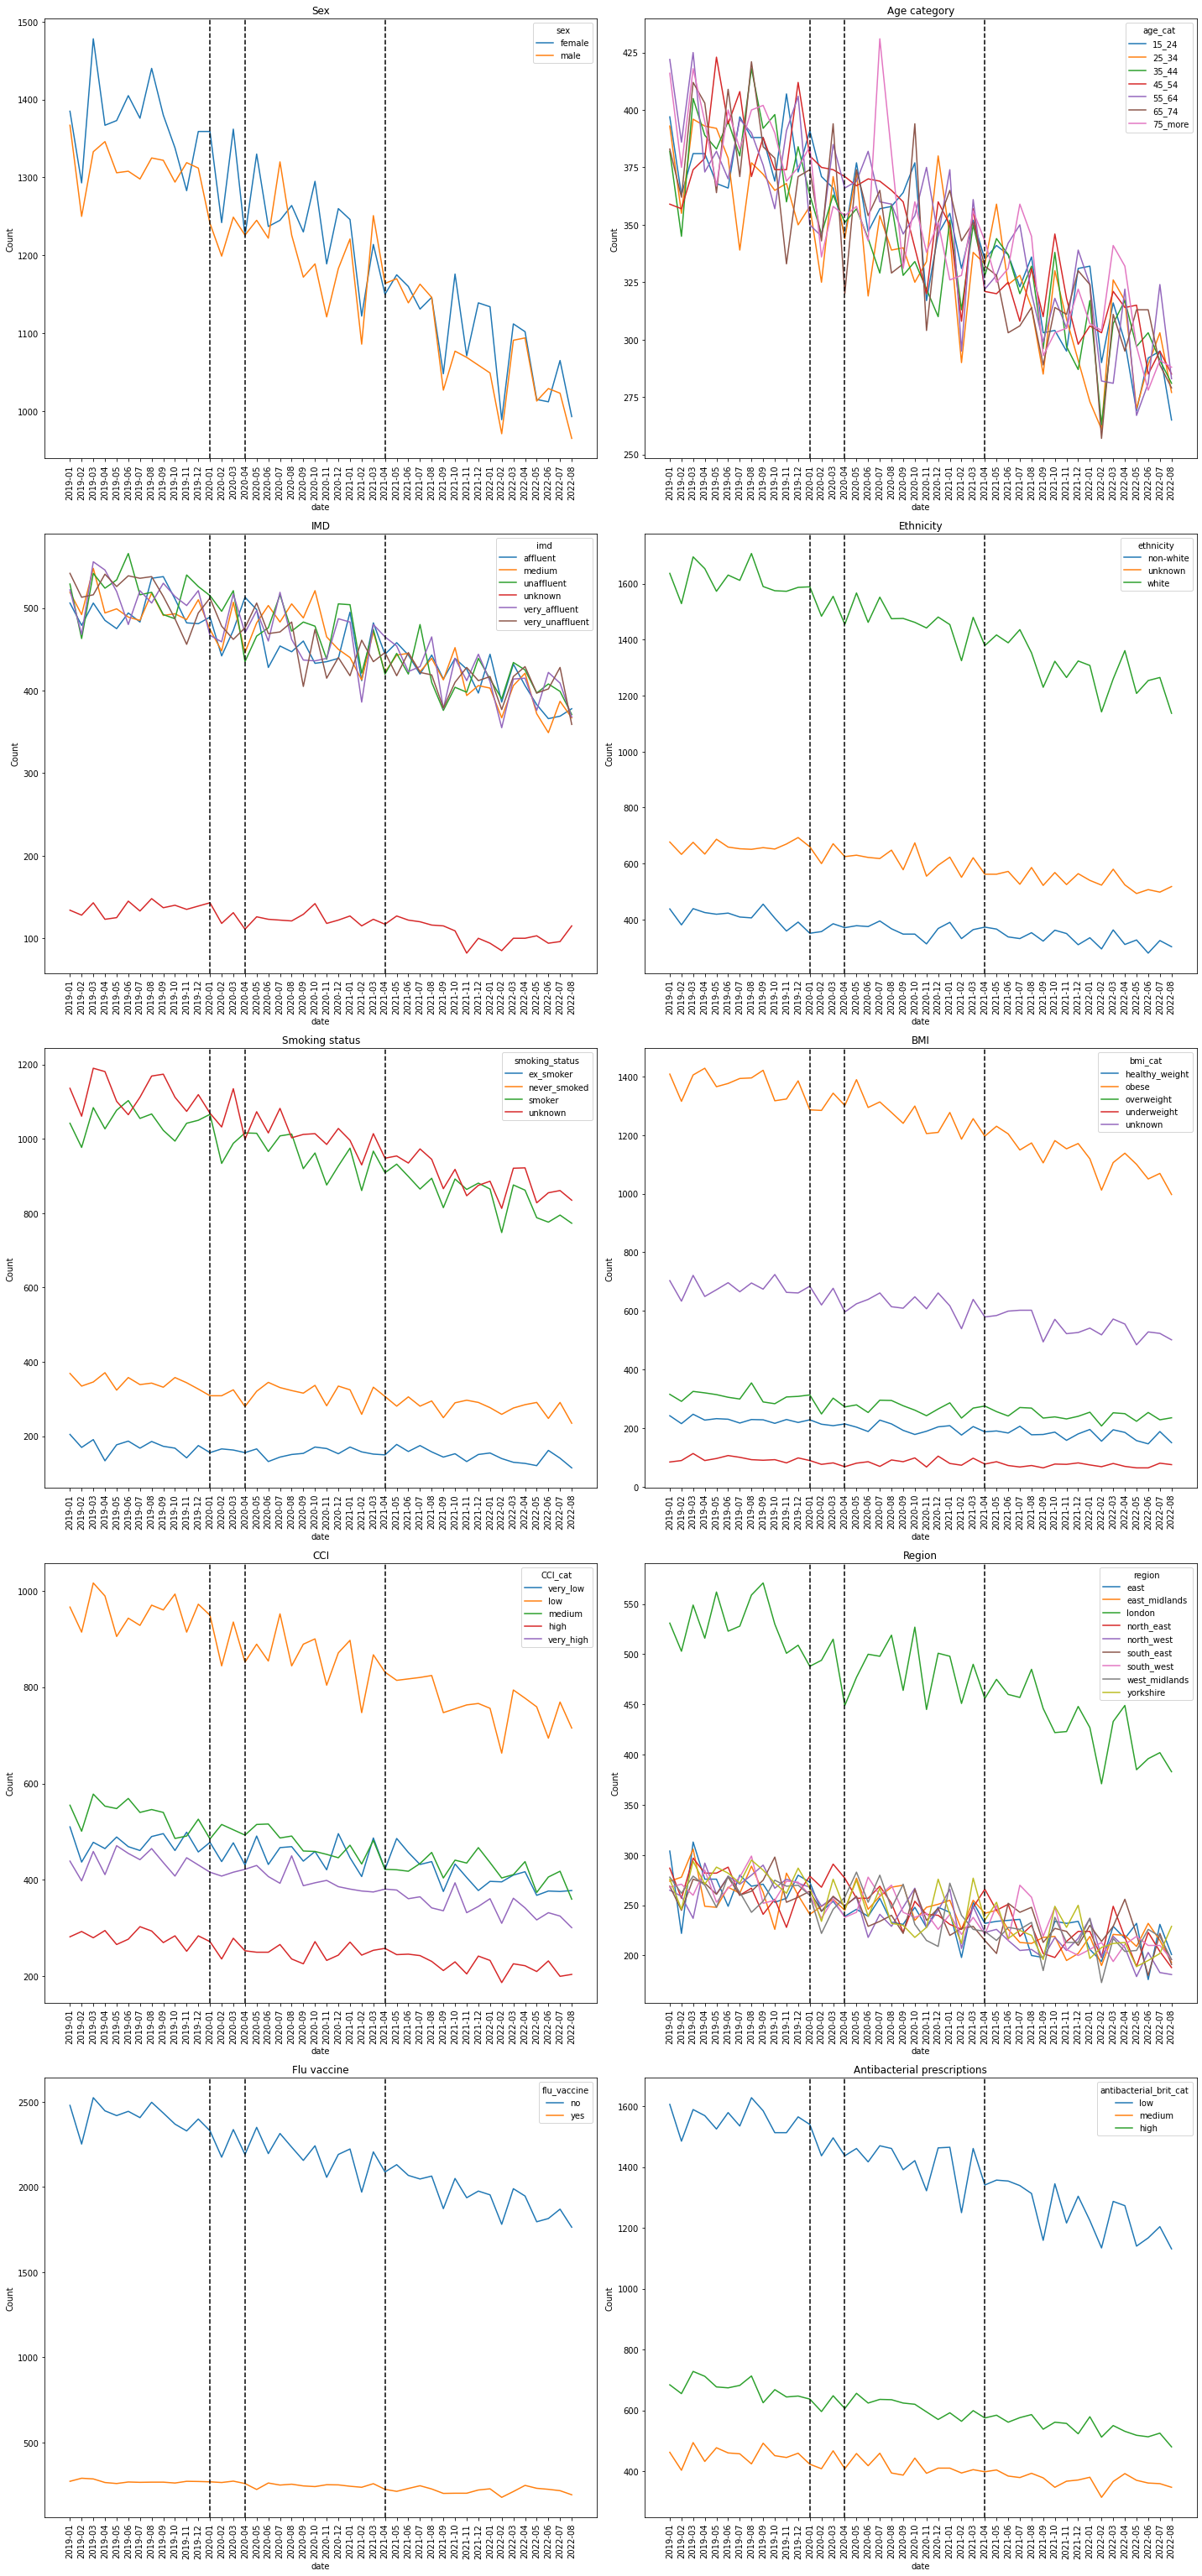

In [66]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_throat, 'sex', 'Sex', axes[0,0])
create_lineplot(data_throat, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_throat, 'imd', 'IMD', axes[1,0])
create_lineplot(data_throat, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_throat, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_throat, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_throat, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_throat, 'region', 'Region', axes[3,1])
create_lineplot(data_throat, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_throat, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of throat patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/risk_factors_cat_throat.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of throat to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [67]:
data_throat = data_throat[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'throat_ab_date', 'ab_type_cat', 'incdt_throat_date', 'date',
                       'event_throat_admitted', 'duration_throat_admitted'
                        ]]

data_throat.shape

(106095, 17)

In [68]:
#incident and prevalent infection 
data_throat_incdt = data_throat[data_throat['incdt_throat_date'] == 0]
data_throat_prevl = data_throat[data_throat['incdt_throat_date'] == 1]
#switch variable throat_ab_date into a binary variable
data_throat_incdt[['throat_ab_date']] = data_throat_incdt[['throat_ab_date']].where(data_throat_incdt[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)
data_throat_prevl[['throat_ab_date']] = data_throat_prevl[['throat_ab_date']].where(data_throat_prevl[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_throat_incdt_males = data_throat_incdt[data_throat_incdt['sex'] == 'male']
data_throat_incdt_females = data_throat_incdt[data_throat_incdt['sex'] == 'female']
data_throat_prevl_males = data_throat_prevl[data_throat_prevl['sex'] == 'male']
data_throat_prevl_females = data_throat_prevl[data_throat_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_throat_incdt_15_24 = data_throat_incdt[data_throat_incdt['age_cat'] == '15_24']
data_throat_incdt_25_34 = data_throat_incdt[data_throat_incdt['age_cat'] == '25_34']
data_throat_incdt_35_44 = data_throat_incdt[data_throat_incdt['age_cat'] == '35_44']
data_throat_incdt_45_54 = data_throat_incdt[data_throat_incdt['age_cat'] == '45_54']
data_throat_incdt_55_64 = data_throat_incdt[data_throat_incdt['age_cat'] == '55_64']
data_throat_incdt_65_74 = data_throat_incdt[data_throat_incdt['age_cat'] == '65_74']
data_throat_incdt_75_more = data_throat_incdt[data_throat_incdt['age_cat'] == '75_more']
data_throat_prevl_15_24 = data_throat_prevl[data_throat_prevl['age_cat'] == '15_24']
data_throat_prevl_25_34 = data_throat_prevl[data_throat_prevl['age_cat'] == '25_34']
data_throat_prevl_35_44 = data_throat_prevl[data_throat_prevl['age_cat'] == '35_44']
data_throat_prevl_45_54 = data_throat_prevl[data_throat_prevl['age_cat'] == '45_54']
data_throat_prevl_55_64 = data_throat_prevl[data_throat_prevl['age_cat'] == '55_64']
data_throat_prevl_65_74 = data_throat_prevl[data_throat_prevl['age_cat'] == '65_74']
data_throat_prevl_75_more = data_throat_prevl[data_throat_prevl['age_cat'] == '75_more']

data_throat_incdt_prepandemic = data_throat_incdt[data_throat_incdt['date'] <= '2019-12']
data_throat_incdt_during_pandemic = data_throat_incdt[(data_throat_incdt['date'] >= '2020-03') & (data_throat_incdt['date']<= '2021-03')]
data_throat_incdt_post_2nd_lockdown = data_throat_incdt[data_throat_incdt['date'] <= '2021-04']
data_throat_prevl_prepandemic = data_throat_prevl[data_throat_prevl['date'] <= '2019-12']
data_throat_prevl_during_pandemic = data_throat_prevl[(data_throat_prevl['date'] >= '2020-03') & (data_throat_prevl['date']<= '2021-03')]
data_throat_prevl_post_2nd_lockdown = data_throat_prevl[data_throat_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_throat_incdt_abtype_0 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[0]]
# data_throat_incdt_abtype_1 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[1]]
# data_throat_incdt_abtype_2 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[2]]
# data_throat_incdt_abtype_3 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[3]]
# data_throat_prevl_abtype_0 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[0]]
# data_throat_prevl_abtype_1 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[1]]
# data_throat_prevl_abtype_2 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[2]]
# data_throat_prevl_abtype_3 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_throat_incdt_abs = data_throat_incdt[data_throat_incdt['throat_ab_date'] == 1]
# data_throat_prevl_abs = data_throat_prevl[data_throat_prevl['throat_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_throat_no_abs_incdt = data_throat[data_throat['throat_ab_date'].isnull()] #gp_cons_throat_ab
data_throat_no_abs_incdt = data_throat_no_abs_incdt[data_throat_no_abs_incdt['incdt_throat_date'] == 0]

# with antibiotics and incident hospital admission
data_throat_abs_incdt = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_incdt = data_throat_abs_incdt[data_throat_abs_incdt['incdt_throat_date'] == 0]

# no antibiotics and prevalent hospital admission
data_throat_no_abs_prevl = data_throat[data_throat['throat_ab_date'].isnull()]
data_throat_no_abs_prevl = data_throat_no_abs_prevl[data_throat_no_abs_prevl['incdt_throat_date'] == 1]

# with antibiotics and prevalent hospital admission
data_throat_abs_prevl = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_prevl = data_throat_abs_prevl[data_throat_abs_prevl['incdt_throat_date'] == 1]

print(f'shape of data_throat_incdt: {data_throat_incdt.shape}')
print(f'shape of data_throat_prevl: {data_throat_prevl.shape}')
print(f'shape of data_throat_no_abs_incdt: {data_throat_no_abs_incdt.shape}')
print(f'shape of data_throat_abs_incdt: {data_throat_abs_incdt.shape}')
print(f'shape of data_throat_no_abs_prevl: {data_throat_no_abs_prevl.shape}')
print(f'shape of data_throat_abs_prevl: {data_throat_abs_prevl.shape}')
print(f'\nvalue counts of data_throat_no_abs_incdt: \n{data_throat_no_abs_incdt.event_throat_admitted.value_counts()}')
print(f'value counts of data_throat_abs_incdt: \n{data_throat_abs_incdt.event_throat_admitted.value_counts()}')
print(f'value counts of data_throat_no_abs_prevl: \n{data_throat_no_abs_prevl.event_throat_admitted.value_counts()}')
print(f'value counts of data_throat_abs_prevl: \n{data_throat_abs_prevl.event_throat_admitted.value_counts()}')

shape of data_throat_incdt: (95577, 17)
shape of data_throat_prevl: (10518, 17)
shape of data_throat_no_abs_incdt: (86076, 17)
shape of data_throat_abs_incdt: (9501, 17)
shape of data_throat_no_abs_prevl: (9405, 17)
shape of data_throat_abs_prevl: (1113, 17)

value counts of data_throat_no_abs_incdt: 
0.0    85402
1.0      674
Name: event_throat_admitted, dtype: int64
value counts of data_throat_abs_incdt: 
0.0    9420
1.0      81
Name: event_throat_admitted, dtype: int64
value counts of data_throat_no_abs_prevl: 
0.0    9338
1.0      67
Name: event_throat_admitted, dtype: int64
value counts of data_throat_abs_prevl: 
0.0    1103
1.0      10
Name: event_throat_admitted, dtype: int64


In [69]:
#store data for plotting hosp admission counts and percentages
%store data_throat
# save data
data_throat.to_csv('../output/hospitalisation_prediction_throat/data_throat.csv')

Stored 'data_throat' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident throat with no antibiotics

<lifelines.CoxPHFitter: fitted with 64557 total observations, 64043 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 64557
number of events observed = 514
   partial log-likelihood = -5670.86
         time fit was run = 2022-11-17 11:36:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.13            -0.13             0.38                 0.88                 1.46
CCI_cat[T.medium]               -0.03       0.97       0.15            -0.32             0.26                 0.73                 1.30
CCI_cat[T.high]                  0.07       1.07       0.17            -0.27             0.41                 0.77                 1.51
CCI_cat[T.very_high]             0.11       1.11       0.15            -0.19             0.40                 0.83                 1.49
age_cat[T.25_34]                 0.20       1.23       0.17            -0.13             0.54                 0.88                 1.71
age_cat[T.35_44]                 0.48       1.62       0.16             0.17             0.80                 1.18                 2.22
age_cat[T.45_54]                 0.28       1.32       0.17            -0.05             0.61                 0.96                 1.84
age_cat[T.55_64]                -0.07       0.93       0.18            -0.42             0.29                 0.65                 1.33
age_cat[T.65_74]                -0.06       0.94       0.18            -0.41             0.30                 0.66                 1.35
age_cat[T.75_more]               0.09       1.10       0.17            -0.25             0.43                 0.78                 1.54
antibacterial_brit               0.01       1.01       0.03            -0.05             0.07                 0.95                 1.08
bmi_cat[T.obese]                 0.01       1.01       0.17            -0.33             0.35                 0.72                 1.41
bmi_cat[T.overweight]            0.32       1.37       0.20            -0.07             0.71                 0.93                 2.03
bmi_cat[T.underweight]           0.05       1.05       0.29            -0.52             0.62                 0.60                 1.86
bmi_cat[T.unknown]               0.15       1.16       0.18            -0.21             0.50                 0.81                 1.65
ethnicity[T.unknown]            -0.07       0.93       0.15            -0.36             0.22                 0.70                 1.24
ethnicity[T.white]               0.02       1.03       0.13            -0.22             0.27                 0.80                 1.31
flu_vaccine[T.yes]               0.04       1.04       0.14            -0.24             0.32                 0.79                 1.38
imd[T.medium]                    0.16       1.17       0.14            -0.11             0.44                 0.89                 1.55
imd[T.unaffluent]               -0.03       0.97       0.15            -0.32             0.26                 0.73                 1.29
imd[T.unknown]                  -0.09       0.91       0.23            -0.55             0.36                 0.58                 1.44
imd[T.very_affluent]            -0.06       0.94       0.15            -0.35             0.22                 0.70                 1.25
imd[T.very_unaffluent]           0.07       1.07       0.14            -0.22             0.35                 0.81                 1.41
region[T.east_midlands]          0.07       1.07       0.19            -0.30             0.45                 0.74                 1.56
region[T.london]                -0.02       0.98       0.17     

12773


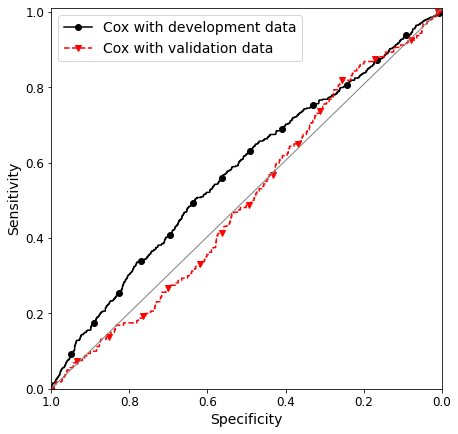

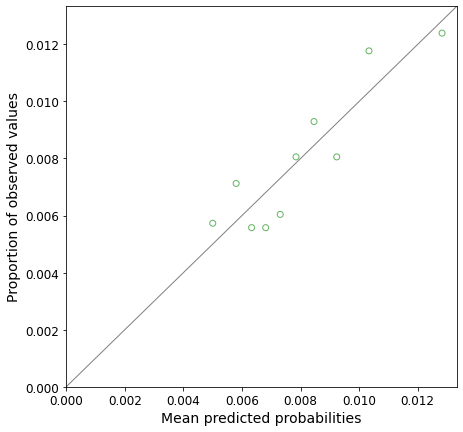

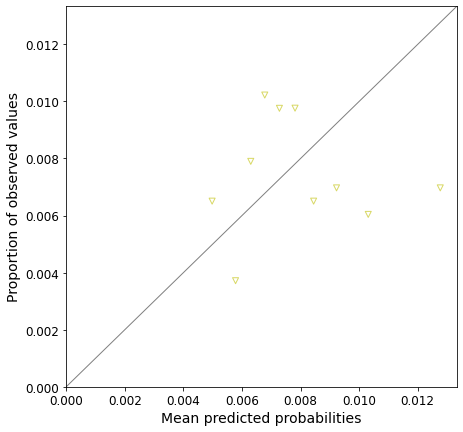

In [70]:
#data prep
data, data_throat_no_abs_incdt_enc = cox_data_prep(data_throat_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'no_abs_incdt', data_throat_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'no_abs_incdt', data_throat_no_abs_incdt)

try:
    #build cox model 
    cph_throat_no_abs_incdt, data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test = cox_model_build('throat', 'no_abs_incdt', data_throat_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_throat_no_abs_incdt, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_no_abs_incdt.csv', data_throat_no_abs_incdt_enc, data_throat_no_abs_incdt, 'sum_betas_cph_throat_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_throat_no_abs_incdt, 'event_throat_admitted', data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_throat_no_abs_incdt, data_throat_no_abs_incdt_train, 'event_throat_admitted', data_throat_no_abs_incdt_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_no_abs_incdt_train.jpg', 'calibration_cph_throat_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_throat_no_abs_incdt, 'throat', 'no_abs_incdt', data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident throat with antibiotics

<lifelines.CoxPHFitter: fitted with 7125 total observations, 7064 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7125
number of events observed = 61
   partial log-likelihood = -524.84
         time fit was run = 2022-11-17 11:37:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.37            -0.48             0.98                 0.62                 2.67
CCI_cat[T.medium]                0.17       1.19       0.43            -0.67             1.02                 0.51                 2.76
CCI_cat[T.high]                  0.11       1.11       0.52            -0.91             1.12                 0.40                 3.07
CCI_cat[T.very_high]            -0.31       0.73       0.49            -1.28             0.66                 0.28                 1.93
age_cat[T.25_34]                 0.22       1.25       0.49            -0.73             1.18                 0.48                 3.25
age_cat[T.35_44]                 0.35       1.43       0.48            -0.58             1.29                 0.56                 3.62
age_cat[T.45_54]                 0.39       1.47       0.47            -0.53             1.30                 0.59                 3.67
age_cat[T.55_64]                -0.65       0.52       0.61            -1.85             0.55                 0.16                 1.74
age_cat[T.65_74]                 0.40       1.49       0.46            -0.50             1.30                 0.61                 3.66
age_cat[T.75_more]              -0.02       0.98       0.52            -1.03             1.00                 0.36                 2.71
antibacterial_brit              -0.19       0.83       0.10            -0.39             0.00                 0.68                 1.00
bmi_cat[T.obese]                 0.11       1.11       0.48            -0.83             1.05                 0.44                 2.85
bmi_cat[T.overweight]           -0.29       0.75       0.64            -1.53             0.96                 0.22                 2.61
bmi_cat[T.underweight]           0.58       1.79       0.67            -0.74             1.90                 0.48                 6.71
bmi_cat[T.unknown]              -0.32       0.73       0.54            -1.38             0.74                 0.25                 2.10
ethnicity[T.unknown]            -0.15       0.86       0.40            -0.93             0.63                 0.39                 1.87
ethnicity[T.white]              -0.23       0.80       0.35            -0.91             0.45                 0.40                 1.57
flu_vaccine[T.yes]              -0.22       0.80       0.47            -1.14             0.69                 0.32                 2.00
imd[T.medium]                    0.13       1.14       0.39            -0.63             0.90                 0.53                 2.45
imd[T.unaffluent]                0.06       1.06       0.39            -0.70             0.82                 0.50                 2.28
imd[T.unknown]                   0.15       1.16       0.58            -0.99             1.28                 0.37                 3.61
imd[T.very_affluent]            -0.28       0.76       0.43            -1.12             0.56                 0.33                 1.75
imd[T.very_unaffluent]          -0.99       0.37       0.53            -2.03             0.06                 0.13                 1.06
region[T.east_midlands]          0.46       1.58       0.56            -0.63             1.56                 0.53                 4.74
region[T.london]                 0.05       1.06       0.54          

12760


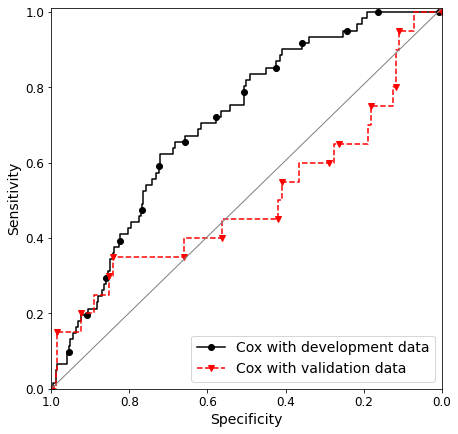

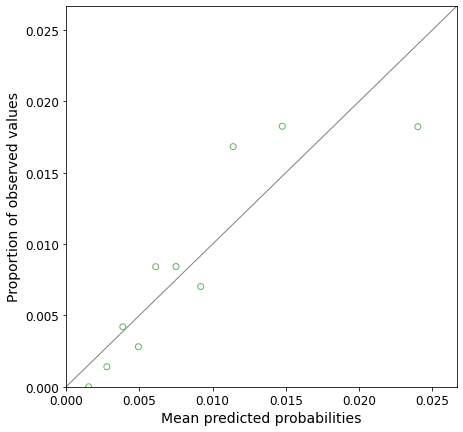

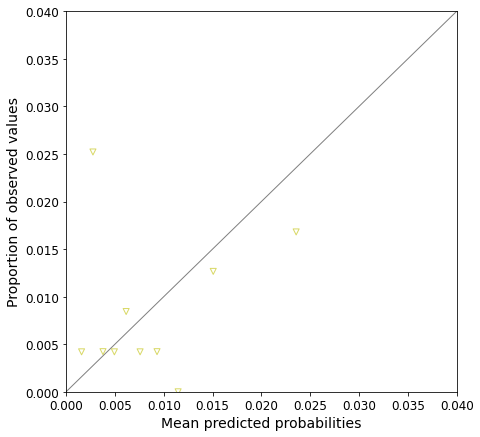

In [71]:
#data prep
data, data_throat_abs_incdt_enc = cox_data_prep(data_throat_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'abs_incdt', data_throat_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'abs_incdt', data_throat_abs_incdt)

try:
    #build cox model 
    cph_throat_abs_incdt, data_throat_abs_incdt_train, data_throat_abs_incdt_test = cox_model_build('throat', 'abs_incdt', data_throat_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_throat_abs_incdt, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_abs_incdt.csv', data_throat_abs_incdt_enc, data_throat_abs_incdt, 'sum_betas_cph_throat_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_throat_abs_incdt, 'event_throat_admitted', data_throat_abs_incdt_train, data_throat_abs_incdt_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_throat_abs_incdt, data_throat_abs_incdt_train, 'event_throat_admitted', data_throat_abs_incdt_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_abs_incdt_train.jpg', 'calibration_cph_throat_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_throat_abs_incdt, 'throat', 'abs_incdt', data_throat_abs_incdt_train, data_throat_abs_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent throat with no antibiotics

<lifelines.CoxPHFitter: fitted with 7053 total observations, 7001 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7053
number of events observed = 52
   partial log-likelihood = -438.35
         time fit was run = 2022-11-17 11:37:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.70       0.49       0.37            -1.42             0.02                 0.24                 1.02
CCI_cat[T.medium]               -0.30       0.74       0.38            -1.05             0.45                 0.35                 1.57
CCI_cat[T.high]                 -0.79       0.45       0.57            -1.90             0.32                 0.15                 1.37
CCI_cat[T.very_high]            -1.00       0.37       0.52            -2.02             0.01                 0.13                 1.01
age_cat[T.25_34]                 1.01       2.74       0.59            -0.15             2.17                 0.86                 8.78
age_cat[T.35_44]                 0.59       1.80       0.63            -0.64             1.82                 0.53                 6.17
age_cat[T.45_54]                 1.03       2.81       0.59            -0.11             2.18                 0.89                 8.86
age_cat[T.55_64]                 1.14       3.14       0.58             0.01             2.28                 1.01                 9.75
age_cat[T.65_74]                 0.43       1.53       0.65            -0.84             1.69                 0.43                 5.45
age_cat[T.75_more]              -0.69       0.50       0.87            -2.39             1.01                 0.09                 2.76
antibacterial_brit               0.07       1.07       0.10            -0.12             0.26                 0.89                 1.30
bmi_cat[T.obese]                -0.10       0.90       0.45            -0.98             0.78                 0.38                 2.18
bmi_cat[T.overweight]           -2.08       0.12       1.08            -4.20             0.04                 0.01                 1.04
bmi_cat[T.underweight]          -0.89       0.41       1.08            -3.02             1.23                 0.05                 3.43
bmi_cat[T.unknown]              -0.40       0.67       0.50            -1.39             0.58                 0.25                 1.79
ethnicity[T.unknown]            -0.55       0.58       0.45            -1.43             0.33                 0.24                 1.39
ethnicity[T.white]              -0.26       0.77       0.36            -0.97             0.46                 0.38                 1.58
flu_vaccine[T.yes]              -0.33       0.72       0.52            -1.36             0.69                 0.26                 2.00
imd[T.medium]                   -0.34       0.71       0.47            -1.25             0.57                 0.29                 1.77
imd[T.unaffluent]               -0.45       0.64       0.48            -1.40             0.50                 0.25                 1.65
imd[T.unknown]                   0.29       1.34       0.59            -0.86             1.44                 0.42                 4.22
imd[T.very_affluent]            -0.02       0.98       0.43            -0.86             0.82                 0.42                 2.26
imd[T.very_unaffluent]          -0.06       0.94       0.43            -0.90             0.78                 0.41                 2.18
region[T.east_midlands]         -1.30       0.27       0.66            -2.59            -0.00                 0.07                 1.00
region[T.london]                -1.21       0.30       0.52          

12789


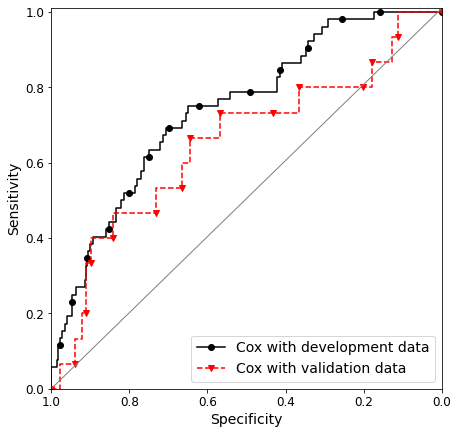

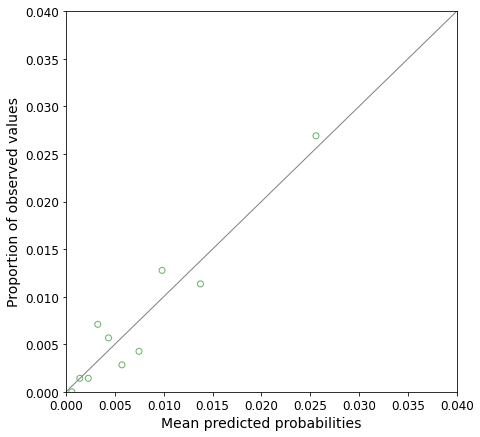

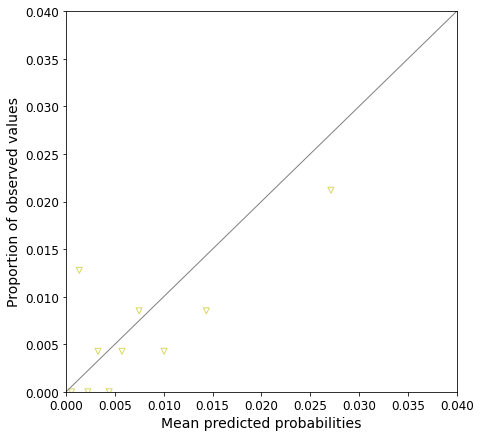

In [72]:
#data prep
data, data_throat_no_abs_prevl_enc = cox_data_prep(data_throat_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'no_abs_prevl', data_throat_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'no_abs_prevl', data_throat_no_abs_prevl)

try:
    #build cox model 
    cph_throat_no_abs_prevl, data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test = cox_model_build('throat', 'no_abs_prevl', data_throat_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_throat_no_abs_prevl, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_no_abs_prevl.csv', data_throat_no_abs_prevl_enc, data_throat_no_abs_prevl, 'sum_betas_cph_throat_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_throat_no_abs_prevl, 'event_throat_admitted', data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_throat_no_abs_prevl, data_throat_no_abs_prevl_train, 'event_throat_admitted', data_throat_no_abs_prevl_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_no_abs_prevl_train.jpg', 'calibration_cph_throat_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_throat_no_abs_prevl, 'throat', 'no_abs_prevl', data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent throat with antibiotics

<lifelines.CoxPHFitter: fitted with 834 total observations, 826 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 834
number of events observed = 8
   partial log-likelihood = -29.38
         time fit was run = 2022-11-17 11:37:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   2.58      13.17       1.77            -0.88             6.04                 0.41               419.52
CCI_cat[T.medium]              -17.33       0.00    6872.44        -13487.07         13452.40                 0.00                  inf
CCI_cat[T.high]                -17.09       0.00    8959.12        -17576.64         17542.46                 0.00                  inf
CCI_cat[T.very_high]             3.07      21.48       1.79            -0.44             6.57                 0.64               716.44
age_cat[T.25_34]                18.93   1.67e+08    7748.96        -15168.75         15206.62                 0.00                  inf
age_cat[T.35_44]                20.17   5.75e+08    7748.96        -15167.52         15207.86                 0.00                  inf
age_cat[T.45_54]                20.23   6.13e+08    7748.96        -15167.45         15207.92                 0.00                  inf
age_cat[T.55_64]                -1.84       0.16   12552.58        -24604.44         24600.76                 0.00                  inf
age_cat[T.65_74]                -1.68       0.19   11843.50        -23214.51         23211.15                 0.00                  inf
age_cat[T.75_more]              17.97   6.38e+07    7748.96        -15169.71         15205.66                 0.00                  inf
antibacterial_brit              -0.82       0.44       0.48            -1.75             0.12                 0.17                 1.13
bmi_cat[T.obese]                -0.56       0.57       1.76            -4.02             2.89                 0.02                18.02
bmi_cat[T.overweight]            1.00       2.71       2.25            -3.42             5.42                 0.03               225.23
bmi_cat[T.underweight]         -19.30       0.00   15030.90        -29479.32         29440.71                 0.00                  inf
bmi_cat[T.unknown]               1.24       3.44       1.94            -2.56             5.04                 0.08               153.94
ethnicity[T.unknown]            -2.94       0.05       2.10            -7.05             1.18                 0.00                 3.25
ethnicity[T.white]              -1.03       0.36       1.66            -4.29             2.22                 0.01                 9.23
flu_vaccine[T.yes]               1.96       7.09       1.66            -1.29             5.21                 0.28               182.65
imd[T.medium]                   -0.67       0.51       1.63            -3.86             2.52                 0.02                12.43
imd[T.unaffluent]                0.49       1.64       1.63            -2.70             3.69                 0.07                39.98
imd[T.unknown]                 -21.93       0.00   12836.41        -25180.84         25136.98                 0.00                  inf
imd[T.very_affluent]            -1.61       0.20       2.15            -5.83             2.61                 0.00                13.55
imd[T.very_unaffluent]          -1.63       0.20       1.88            -5.32             2.06                 0.00                 7.87
region[T.east_midlands]         -0.63       0.53   15115.06        -29625.60         29624.35                 0.00                  inf
region[T.london]                18.85   1.54e+08   10539.15        -20637.

13076


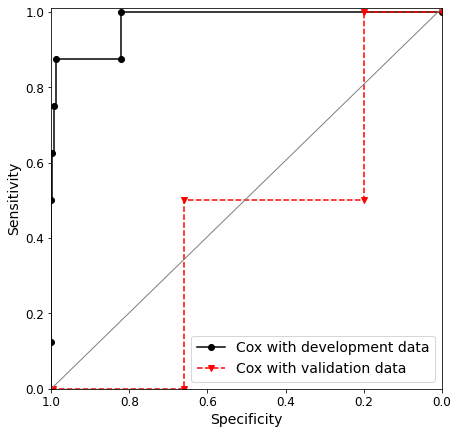

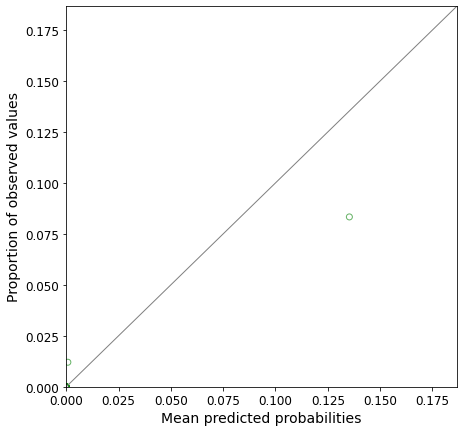

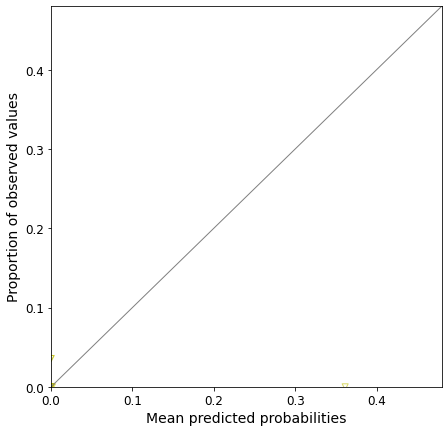

In [73]:
#data prep
data, data_throat_abs_prevl_enc = cox_data_prep(data_throat_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'abs_prevl', data_throat_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'abs_prevl', data_throat_abs_prevl)

try:
    #build cox model 
    cph_throat_abs_prevl, data_throat_abs_prevl_train, data_throat_abs_prevl_test = cox_model_build('throat', 'abs_prevl', data_throat_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_throat_abs_prevl, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_abs_prevl.csv', data_throat_abs_prevl_enc, data_throat_abs_prevl, 'sum_betas_cph_throat_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_throat_abs_prevl, 'event_throat_admitted', data_throat_abs_prevl_train, data_throat_abs_prevl_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_throat_abs_prevl, data_throat_abs_prevl_train, 'event_throat_admitted', data_throat_abs_prevl_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_abs_prevl_train.jpg', 'calibration_cph_throat_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_throat_abs_prevl, 'throat', 'abs_prevl', data_throat_abs_prevl_train, data_throat_abs_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident throat

In [74]:
#data prep
data, data_throat_incdt_enc = cox_data_prep(data_throat_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary tables from preped data
make_summary_table('throat', 'incdt', data_throat_incdt_enc)
make_summary_table_hosped('throat', 'incdt', data_throat_incdt)

try:
    cph_throat_incdt, data_throat_incdt_train, data_throat_incdt_test = cox_model_abs_build('throat', 'incdt', data_throat_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_incdt, 'throat', 'incdt', data_throat_incdt_train, data_throat_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71682 total observations, 71128 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 71682
number of events observed = 554
   partial log-likelihood = -6175.59
         time fit was run = 2022-11-17 11:37:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
CCI_cat[T.medium]                0.03       1.03       0.14            -0.24             0.31                 0.78                 1.36
CCI_cat[T.high]                 -0.00       1.00       0.17            -0.33             0.33                 0.72                 1.39
CCI_cat[T.very_high]             0.09       1.09       0.14            -0.20             0.37                 0.82                 1.45
age_cat[T.25_34]                 0.10       1.10       0.16            -0.22             0.41                 0.80                 1.51
age_cat[T.35_44]                 0.34       1.41       0.15             0.04             0.64                 1.04                 1.90
age_cat[T.45_54]                 0.13       1.14       0.16            -0.18             0.45                 0.83                 1.56
age_cat[T.55_64]                -0.16       0.86       0.17            -0.49             0.18                 0.61                 1.20
age_cat[T.65_74]                 0.01       1.01       0.17            -0.31             0.34                 0.73                 1.40
age_cat[T.75_more]               0.11       1.12       0.16            -0.20             0.43                 0.82                 1.53
antibacterial_brit               0.03       1.03       0.03            -0.02             0.09                 0.98                 1.10
bmi_cat[T.obese]                 0.15       1.16       0.17            -0.19             0.48                 0.83                 1.62
bmi_cat[T.overweight]            0.33       1.40       0.20            -0.05             0.72                 0.95                 2.06
bmi_cat[T.underweight]           0.05       1.05       0.29            -0.52             0.62                 0.60                 1.86
bmi_cat[T.unknown]               0.16       1.17       0.18            -0.20             0.51                 0.82                 1.67
ethnicity[T.unknown]            -0.12       0.89       0.13            -0.38             0.15                 0.68                 1.16
ethnicity[T.white]              -0.16       0.86       0.12            -0.39             0.07                 0.68                 1.08
flu_vaccine[T.yes]               0.01       1.01       0.14            -0.26             0.29                 0.77                 1.33
imd[T.medium]                    0.09       1.10       0.13            -0.17             0.36                 0.85                 1.43
imd[T.unaffluent]               -0.14       0.87       0.14            -0.42             0.13                 0.66                 1.14
imd[T.unknown]                   0.01       1.01       0.21            -0.39             0.42                 0.68                 1.52
imd[T.very_affluent]            -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
imd[T.very_unaffluent]          -0.10       0.90       0.14            -0.38             0.17                 0.69                 1.19
region[T.east_midlands]          0.24       1.27       0.19            -0.13             0.61                 0.87                 1.83
region[T.london]                 0.07       1.07       0.17     

13024


### 5-6- hospital admission related to prevalent throat

In [75]:
#data prep
data, data_throat_prevl_enc = cox_data_prep(data_throat_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary tables from preped data
make_summary_table('throat', 'prevl', data_throat_prevl_enc)
make_summary_table_hosped('throat', 'prevl', data_throat_prevl)

try:
    cph_throat_prevl, data_throat_prevl_train, data_throat_prevl_test = cox_model_abs_build('throat', 'prevl', data_throat_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl, 'throat', 'prevl', data_throat_prevl_train, data_throat_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7888 total observations, 7830 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7888
number of events observed = 58
   partial log-likelihood = -501.42
         time fit was run = 2022-11-17 11:37:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.34            -1.10             0.24                 0.33                 1.27
CCI_cat[T.medium]               -0.33       0.72       0.38            -1.07             0.42                 0.34                 1.52
CCI_cat[T.high]                 -1.14       0.32       0.63            -2.39             0.10                 0.09                 1.10
CCI_cat[T.very_high]            -0.65       0.52       0.46            -1.56             0.25                 0.21                 1.28
age_cat[T.25_34]                 0.96       2.60       0.53            -0.08             1.99                 0.92                 7.33
age_cat[T.35_44]                 0.45       1.57       0.57            -0.67             1.57                 0.51                 4.81
age_cat[T.45_54]                 0.64       1.91       0.55            -0.43             1.72                 0.65                 5.59
age_cat[T.55_64]                 0.91       2.49       0.53            -0.12             1.95                 0.89                 7.02
age_cat[T.65_74]                 0.12       1.13       0.61            -1.07             1.31                 0.34                 3.71
age_cat[T.75_more]              -0.57       0.57       0.73            -2.00             0.87                 0.14                 2.38
antibacterial_brit               0.03       1.03       0.09            -0.15             0.21                 0.86                 1.24
bmi_cat[T.obese]                -0.08       0.92       0.44            -0.95             0.79                 0.39                 2.20
bmi_cat[T.overweight]           -1.05       0.35       0.71            -2.44             0.34                 0.09                 1.40
bmi_cat[T.underweight]          -0.32       0.73       0.82            -1.92             1.29                 0.15                 3.64
bmi_cat[T.unknown]              -0.53       0.59       0.51            -1.53             0.46                 0.22                 1.59
ethnicity[T.unknown]            -0.59       0.56       0.42            -1.41             0.24                 0.24                 1.27
ethnicity[T.white]              -0.33       0.72       0.34            -0.99             0.33                 0.37                 1.39
flu_vaccine[T.yes]              -0.42       0.66       0.52            -1.44             0.60                 0.24                 1.83
imd[T.medium]                   -0.63       0.53       0.47            -1.55             0.29                 0.21                 1.34
imd[T.unaffluent]               -0.15       0.86       0.41            -0.96             0.65                 0.38                 1.92
imd[T.unknown]                   0.17       1.18       0.57            -0.96             1.29                 0.38                 3.64
imd[T.very_affluent]            -0.30       0.74       0.42            -1.13             0.53                 0.32                 1.69
imd[T.very_unaffluent]          -0.04       0.96       0.39            -0.81             0.73                 0.45                 2.08
region[T.east_midlands]         -0.93       0.39       0.68            -2.26             0.40                 0.10                 1.49
region[T.london]                -0.55       0.58       0.49          

13053


### 5-7- hospital admission related to incident throat with prescribed antibiotics categories

In [76]:
#data prep
data, data_throat_incdt_abs_enc = cox_data_prep(data_throat_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_abs, data_throat_incdt_abs_train, data_throat_incdt_abs_test = cox_model_ab_type_build('throat', 'incdt_ab_type', data_throat_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_abs, 'throat', 'incdt_abs', data_throat_incdt_abs_train, data_throat_incdt_abs_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71682 total observations, 71128 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 71682
number of events observed = 554
   partial log-likelihood = -6174.33
         time fit was run = 2022-11-17 11:37:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
CCI_cat[T.medium]                0.03       1.03       0.14            -0.24             0.31                 0.79                 1.36
CCI_cat[T.high]                 -0.00       1.00       0.17            -0.33             0.33                 0.72                 1.39
CCI_cat[T.very_high]             0.09       1.09       0.14            -0.20             0.37                 0.82                 1.45
ab_type_cat[T.Doxycycline]       1.22       3.37       1.41            -1.56             3.99                 0.21                53.97
ab_type_cat[T.no]                1.19       3.30       1.00            -0.77             3.16                 0.46                23.47
ab_type_cat[T.other]             1.28       3.59       1.01            -0.70             3.26                 0.50                25.97
age_cat[T.25_34]                 0.10       1.10       0.16            -0.22             0.41                 0.80                 1.51
age_cat[T.35_44]                 0.34       1.41       0.15             0.04             0.64                 1.04                 1.90
age_cat[T.45_54]                 0.13       1.14       0.16            -0.18             0.45                 0.83                 1.56
age_cat[T.55_64]                -0.16       0.86       0.17            -0.49             0.18                 0.61                 1.20
age_cat[T.65_74]                 0.01       1.01       0.17            -0.31             0.34                 0.73                 1.40
age_cat[T.75_more]               0.11       1.12       0.16            -0.20             0.43                 0.82                 1.54
antibacterial_brit               0.03       1.04       0.03            -0.02             0.09                 0.98                 1.10
bmi_cat[T.obese]                 0.15       1.16       0.17            -0.19             0.48                 0.83                 1.62
bmi_cat[T.overweight]            0.33       1.40       0.20            -0.05             0.72                 0.95                 2.06
bmi_cat[T.underweight]           0.05       1.05       0.29            -0.52             0.62                 0.60                 1.86
bmi_cat[T.unknown]               0.16       1.17       0.18            -0.20             0.51                 0.82                 1.67
ethnicity[T.unknown]            -0.12       0.89       0.13            -0.38             0.15                 0.69                 1.16
ethnicity[T.white]              -0.15       0.86       0.12            -0.38             0.08                 0.68                 1.08
flu_vaccine[T.yes]               0.01       1.01       0.14            -0.26             0.28                 0.77                 1.33
imd[T.medium]                    0.09       1.10       0.13            -0.17             0.36                 0.85                 1.43
imd[T.unaffluent]               -0.14       0.87       0.14            -0.42             0.13                 0.66                 1.14
imd[T.unknown]                   0.01       1.01       0.21            -0.39             0.42                 0.68                 1.52
imd[T.very_affluent]            -0.06       0.95       0.14     

13588


### 5-8- hospital admission related to prevalent throat with prescribed antibiotics categories

In [77]:
#data prep
data, data_throat_prevl_abs_enc = cox_data_prep(data_throat_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_abs, data_throat_prevl_abs_train, data_throat_prevl_abs_test = cox_model_ab_type_build('throat', 'prevl_ab_type', data_throat_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_abs, 'throat', 'prevl_abs', data_throat_prevl_abs_train, data_throat_prevl_abs_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7888 total observations, 7830 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7888
number of events observed = 58
   partial log-likelihood = -501.09
         time fit was run = 2022-11-17 11:37:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.34            -1.10             0.24                 0.33                 1.27
CCI_cat[T.medium]               -0.33       0.72       0.38            -1.08             0.42                 0.34                 1.52
CCI_cat[T.high]                 -1.15       0.32       0.63            -2.39             0.09                 0.09                 1.10
CCI_cat[T.very_high]            -0.66       0.52       0.46            -1.56             0.24                 0.21                 1.28
ab_type_cat[T.Doxycycline]     -14.60       0.00    2691.55         -5289.94          5260.73                 0.00                  inf
ab_type_cat[T.no]               -1.13       0.32       1.02            -3.12             0.87                 0.04                 2.38
ab_type_cat[T.other]            -0.68       0.51       1.07            -2.78             1.42                 0.06                 4.12
age_cat[T.25_34]                 0.96       2.61       0.53            -0.08             1.99                 0.93                 7.34
age_cat[T.35_44]                 0.46       1.58       0.57            -0.66             1.58                 0.52                 4.86
age_cat[T.45_54]                 0.65       1.92       0.55            -0.43             1.73                 0.65                 5.62
age_cat[T.55_64]                 0.91       2.49       0.53            -0.12             1.95                 0.89                 7.00
age_cat[T.65_74]                 0.12       1.13       0.61            -1.07             1.31                 0.34                 3.72
age_cat[T.75_more]              -0.57       0.56       0.73            -2.01             0.86                 0.13                 2.37
antibacterial_brit               0.03       1.03       0.09            -0.15             0.21                 0.86                 1.24
bmi_cat[T.obese]                -0.08       0.93       0.44            -0.95             0.79                 0.39                 2.20
bmi_cat[T.overweight]           -1.05       0.35       0.71            -2.44             0.34                 0.09                 1.40
bmi_cat[T.underweight]          -0.30       0.74       0.82            -1.91             1.30                 0.15                 3.68
bmi_cat[T.unknown]              -0.54       0.59       0.51            -1.53             0.46                 0.22                 1.59
ethnicity[T.unknown]            -0.58       0.56       0.42            -1.40             0.24                 0.25                 1.28
ethnicity[T.white]              -0.32       0.72       0.34            -0.99             0.34                 0.37                 1.40
flu_vaccine[T.yes]              -0.41       0.66       0.52            -1.43             0.61                 0.24                 1.84
imd[T.medium]                   -0.63       0.53       0.47            -1.55             0.30                 0.21                 1.34
imd[T.unaffluent]               -0.15       0.86       0.41            -0.96             0.65                 0.38                 1.92
imd[T.unknown]                   0.17       1.19       0.57            -0.95             1.30                 0.39                 3.66
imd[T.very_affluent]            -0.30       0.74       0.42          

13629


### 5-9- stratified by sex
#### 5-9-1- incident males

In [78]:
#data prep
data, data_throat_incdt_males_enc = cox_data_prep(data_throat_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_males, data_throat_incdt_males_train, data_throat_incdt_males_test = cox_model_strat_sex_build('throat', 'incdt_males', data_throat_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_males, 'throat', 'incdt_males', data_throat_incdt_males_train, data_throat_incdt_males_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35286 total observations, 34998 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 35286
number of events observed = 288
   partial log-likelihood = -2996.65
         time fit was run = 2022-11-17 11:37:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.20       1.22       0.18            -0.16             0.55                 0.85                 1.74
CCI_cat[T.medium]                0.17       1.18       0.20            -0.23             0.57                 0.79                 1.76
CCI_cat[T.high]                  0.23       1.26       0.24            -0.23             0.69                 0.79                 2.00
CCI_cat[T.very_high]             0.38       1.47       0.20            -0.02             0.78                 0.98                 2.18
age_cat[T.25_34]                 0.23       1.26       0.21            -0.19             0.65                 0.83                 1.91
age_cat[T.35_44]                 0.42       1.52       0.20             0.02             0.82                 1.02                 2.27
age_cat[T.45_54]                -0.04       0.96       0.23            -0.48             0.40                 0.62                 1.50
age_cat[T.55_64]                -0.25       0.78       0.24            -0.71             0.22                 0.49                 1.24
age_cat[T.65_74]                -0.24       0.79       0.24            -0.70             0.23                 0.49                 1.25
age_cat[T.75_more]              -0.16       0.86       0.23            -0.61             0.30                 0.54                 1.35
antibacterial_brit               0.01       1.01       0.04            -0.07             0.10                 0.94                 1.10
bmi_cat[T.obese]                -0.13       0.88       0.22            -0.56             0.29                 0.57                 1.34
bmi_cat[T.overweight]           -0.01       0.99       0.26            -0.53             0.50                 0.59                 1.66
bmi_cat[T.underweight]          -0.26       0.77       0.41            -1.06             0.54                 0.35                 1.71
bmi_cat[T.unknown]               0.07       1.07       0.23            -0.38             0.51                 0.68                 1.67
ethnicity[T.unknown]            -0.05       0.95       0.20            -0.44             0.34                 0.65                 1.40
ethnicity[T.white]               0.06       1.07       0.17            -0.27             0.40                 0.76                 1.49
flu_vaccine[T.yes]               0.16       1.17       0.18            -0.20             0.52                 0.82                 1.68
imd[T.medium]                    0.09       1.10       0.19            -0.29             0.47                 0.75                 1.60
imd[T.unaffluent]                0.19       1.21       0.19            -0.18             0.56                 0.84                 1.75
imd[T.unknown]                  -0.09       0.92       0.31            -0.70             0.52                 0.50                 1.68
imd[T.very_affluent]            -0.02       0.98       0.20            -0.41             0.36                 0.66                 1.44
imd[T.very_unaffluent]           0.05       1.05       0.20            -0.33             0.44                 0.72                 1.55
region[T.east_midlands]          0.41       1.51       0.26            -0.10             0.93                 0.90                 2.53
region[T.london]                 0.03       1.03       0.25     

12772


#### 5-9-2- incident females

In [79]:
#data prep
data, data_throat_incdt_females_enc = cox_data_prep(data_throat_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_females, data_throat_incdt_females_train, data_throat_incdt_females_test = cox_model_strat_sex_build('throat', 'incdt_females', data_throat_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_females, 'throat', 'incdt_females', data_throat_incdt_females_train, data_throat_incdt_females_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36396 total observations, 36131 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 36396
number of events observed = 265
   partial log-likelihood = -2767.25
         time fit was run = 2022-11-17 11:37:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.93       0.17            -0.42             0.27                 0.66                 1.31
CCI_cat[T.medium]               -0.03       0.98       0.20            -0.41             0.36                 0.67                 1.43
CCI_cat[T.high]                 -0.13       0.88       0.24            -0.61             0.35                 0.54                 1.41
CCI_cat[T.very_high]            -0.01       0.99       0.20            -0.41             0.38                 0.66                 1.47
age_cat[T.25_34]                 0.03       1.04       0.24            -0.44             0.51                 0.64                 1.67
age_cat[T.35_44]                 0.31       1.36       0.23            -0.14             0.76                 0.87                 2.14
age_cat[T.45_54]                 0.28       1.32       0.23            -0.18             0.73                 0.84                 2.08
age_cat[T.55_64]                 0.00       1.00       0.25            -0.48             0.48                 0.62                 1.62
age_cat[T.65_74]                 0.05       1.05       0.24            -0.43             0.53                 0.65                 1.70
age_cat[T.75_more]               0.28       1.32       0.23            -0.17             0.73                 0.84                 2.07
antibacterial_brit              -0.01       0.99       0.04            -0.09             0.08                 0.91                 1.08
bmi_cat[T.obese]                -0.05       0.95       0.23            -0.49             0.39                 0.61                 1.48
bmi_cat[T.overweight]            0.13       1.14       0.27            -0.39             0.66                 0.67                 1.93
bmi_cat[T.underweight]          -0.32       0.72       0.43            -1.17             0.52                 0.31                 1.69
bmi_cat[T.unknown]              -0.09       0.92       0.24            -0.56             0.39                 0.57                 1.48
ethnicity[T.unknown]            -0.25       0.78       0.19            -0.62             0.13                 0.54                 1.14
ethnicity[T.white]              -0.20       0.82       0.17            -0.52             0.13                 0.59                 1.14
flu_vaccine[T.yes]               0.01       1.01       0.20            -0.39             0.41                 0.68                 1.50
imd[T.medium]                    0.14       1.15       0.19            -0.23             0.51                 0.79                 1.66
imd[T.unaffluent]               -0.22       0.80       0.20            -0.62             0.18                 0.54                 1.20
imd[T.unknown]                  -0.45       0.64       0.36            -1.16             0.25                 0.31                 1.29
imd[T.very_affluent]            -0.11       0.89       0.20            -0.50             0.28                 0.60                 1.32
imd[T.very_unaffluent]          -0.07       0.94       0.20            -0.45             0.32                 0.64                 1.38
region[T.east_midlands]          0.11       1.11       0.28            -0.45             0.66                 0.64                 1.94
region[T.london]                 0.19       1.21       0.24     

12771


#### 5-9-3- prevalent males

In [80]:
#data prep
data, data_throat_prevl_males_enc = cox_data_prep(data_throat_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_males, data_throat_prevl_males_train, data_throat_prevl_males_test = cox_model_strat_sex_build('throat', 'prevl_males', data_throat_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_throat_prevl_males, 'throat', 'prevl_males', data_throat_prevl_males_train, data_throat_prevl_males_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3848 total observations, 3820 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 3848
number of events observed = 28
   partial log-likelihood = -207.38
         time fit was run = 2022-11-17 11:37:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.48            -1.28             0.61                 0.28                 1.84
CCI_cat[T.medium]               -1.37       0.25       0.80            -2.94             0.19                 0.05                 1.21
CCI_cat[T.high]                 -1.48       0.23       1.07            -3.57             0.61                 0.03                 1.85
CCI_cat[T.very_high]             0.17       1.19       0.53            -0.86             1.20                 0.42                 3.33
age_cat[T.25_34]                 1.97       7.18       1.07            -0.13             4.08                 0.87                58.93
age_cat[T.35_44]                 2.13       8.42       1.07             0.04             4.22                 1.04                68.08
age_cat[T.45_54]                 0.09       1.10       1.42            -2.69             2.87                 0.07                17.68
age_cat[T.55_64]                 1.84       6.29       1.08            -0.29             3.97                 0.75                52.74
age_cat[T.65_74]                 0.54       1.72       1.23            -1.87             2.95                 0.15                19.20
age_cat[T.75_more]               1.12       3.06       1.16            -1.16             3.40                 0.31                29.83
antibacterial_brit               0.07       1.07       0.13            -0.19             0.32                 0.83                 1.38
bmi_cat[T.obese]                -0.04       0.96       0.63            -1.28             1.20                 0.28                 3.31
bmi_cat[T.overweight]           -0.61       0.54       0.92            -2.42             1.20                 0.09                 3.32
bmi_cat[T.underweight]          -0.22       0.80       1.17            -2.51             2.06                 0.08                 7.85
bmi_cat[T.unknown]              -0.93       0.39       0.77            -2.45             0.58                 0.09                 1.79
ethnicity[T.unknown]             0.58       1.78       0.81            -1.01             2.16                 0.37                 8.71
ethnicity[T.white]               0.80       2.22       0.75            -0.67             2.27                 0.51                 9.63
flu_vaccine[T.yes]              -1.16       0.31       1.03            -3.17             0.86                 0.04                 2.36
imd[T.medium]                    0.21       1.23       0.61            -0.99             1.41                 0.37                 4.10
imd[T.unaffluent]               -0.03       0.97       0.64            -1.28             1.23                 0.28                 3.41
imd[T.unknown]                   0.48       1.61       0.85            -1.18             2.14                 0.31                 8.48
imd[T.very_affluent]            -0.47       0.63       0.73            -1.91             0.97                 0.15                 2.64
imd[T.very_unaffluent]           0.20       1.22       0.59            -0.96             1.36                 0.38                 3.89
region[T.east_midlands]        -17.62       0.00    2867.23         -5637.29          5602.05                 0.00                  inf
region[T.london]                -0.93       0.40       0.61          

12792


#### 5-9-4- prevalent females

In [81]:
try:
    #data prep
    data, data_throat_prevl_females_enc = cox_data_prep(data_throat_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

    #cox model
    cph_throat_prevl_females, data_throat_prevl_females_train, data_throat_prevl_females_test = cox_model_strat_sex_build('throat', 'prevl_females', data_throat_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_females, 'throat', 'prevl_females', data_throat_prevl_females_train, data_throat_prevl_females_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4040 total observations, 4014 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 4040
number of events observed = 26
   partial log-likelihood = -185.84
         time fit was run = 2022-11-17 11:37:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.75       0.47       0.56            -1.85             0.36                 0.16                 1.43
CCI_cat[T.medium]                0.26       1.29       0.51            -0.74             1.25                 0.48                 3.48
CCI_cat[T.high]                 -0.34       0.71       0.70            -1.72             1.04                 0.18                 2.83
CCI_cat[T.very_high]           -18.44       0.00    3885.19         -7633.27          7596.39                 0.00                  inf
age_cat[T.25_34]                 1.21       3.34       0.81            -0.38             2.79                 0.69                16.30
age_cat[T.35_44]                -0.66       0.51       1.23            -3.08             1.75                 0.05                 5.73
age_cat[T.45_54]                 1.53       4.62       0.79            -0.02             3.08                 0.98                21.70
age_cat[T.55_64]                 0.73       2.08       0.87            -0.98             2.44                 0.38                11.52
age_cat[T.65_74]                -0.09       0.91       1.01            -2.07             1.89                 0.13                 6.60
age_cat[T.75_more]              -0.78       0.46       1.23            -3.20             1.64                 0.04                 5.13
antibacterial_brit               0.09       1.09       0.14            -0.18             0.36                 0.83                 1.43
bmi_cat[T.obese]                -0.12       0.89       0.65            -1.39             1.14                 0.25                 3.14
bmi_cat[T.overweight]           -1.55       0.21       1.17            -3.84             0.75                 0.02                 2.12
bmi_cat[T.underweight]         -18.72       0.00    7993.80        -15686.28         15648.85                 0.00                  inf
bmi_cat[T.unknown]              -0.47       0.63       0.72            -1.89             0.95                 0.15                 2.60
ethnicity[T.unknown]            -2.62       0.07       1.08            -4.73            -0.51                 0.01                 0.60
ethnicity[T.white]              -0.57       0.56       0.46            -1.47             0.33                 0.23                 1.39
flu_vaccine[T.yes]              -0.38       0.68       0.75            -1.85             1.09                 0.16                 2.97
imd[T.medium]                   -0.86       0.42       0.87            -2.57             0.85                 0.08                 2.33
imd[T.unaffluent]                0.51       1.66       0.66            -0.78             1.79                 0.46                 6.01
imd[T.unknown]                  -0.06       0.94       1.14            -2.30             2.17                 0.10                 8.77
imd[T.very_affluent]             0.48       1.62       0.64            -0.77             1.74                 0.46                 5.67
imd[T.very_unaffluent]           0.39       1.48       0.66            -0.90             1.68                 0.41                 5.36
region[T.east_midlands]         -1.10       0.33       1.16            -3.38             1.19                 0.03                 3.27
region[T.london]                -0.72       0.49       0.83          

12811


### 5-10- stratified by age category
#### 5-10-1- incident

In [82]:
#data prep
data, data_throat_incdt_15_24_enc = cox_data_prep(data_throat_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_15_24, data_throat_incdt_15_24_train, data_throat_incdt_15_24_test = cox_model_strat_age_build('throat', 'incdt_15_24', data_throat_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_15_24, 'throat', 'incdt_15_24', data_throat_incdt_15_24_train, data_throat_incdt_15_24_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10273 total observations, 10198 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10273
number of events observed = 75
   partial log-likelihood = -677.07
         time fit was run = 2022-11-17 11:37:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.34            -0.39             0.95                 0.67                 2.58
CCI_cat[T.medium]                0.23       1.26       0.39            -0.53             1.00                 0.59                 2.71
CCI_cat[T.high]                  0.25       1.29       0.44            -0.62             1.12                 0.54                 3.06
CCI_cat[T.very_high]            -0.15       0.86       0.44            -1.02             0.71                 0.36                 2.04
antibacterial_brit               0.06       1.06       0.08            -0.10             0.22                 0.90                 1.24
bmi_cat[T.obese]                -0.87       0.42       0.36            -1.57            -0.16                 0.21                 0.85
bmi_cat[T.overweight]           -0.23       0.79       0.43            -1.07             0.61                 0.34                 1.83
bmi_cat[T.underweight]          -1.49       0.22       1.05            -3.54             0.56                 0.03                 1.75
bmi_cat[T.unknown]              -0.24       0.79       0.36            -0.95             0.47                 0.39                 1.60
ethnicity[T.unknown]             0.12       1.12       0.38            -0.62             0.85                 0.54                 2.35
ethnicity[T.white]               0.02       1.02       0.34            -0.65             0.68                 0.52                 1.97
flu_vaccine[T.yes]               0.53       1.69       0.32            -0.09             1.15                 0.91                 3.15
imd[T.medium]                    0.21       1.23       0.35            -0.48             0.90                 0.62                 2.45
imd[T.unaffluent]               -0.19       0.83       0.38            -0.93             0.56                 0.39                 1.75
imd[T.unknown]                  -0.76       0.47       0.75            -2.24             0.72                 0.11                 2.05
imd[T.very_affluent]            -0.11       0.90       0.37            -0.84             0.62                 0.43                 1.86
imd[T.very_unaffluent]          -0.11       0.89       0.38            -0.86             0.63                 0.42                 1.88
region[T.east_midlands]         -0.45       0.64       0.57            -1.57             0.67                 0.21                 1.95
region[T.london]                -0.06       0.94       0.44            -0.92             0.80                 0.40                 2.22
region[T.north_east]             0.25       1.29       0.48            -0.68             1.18                 0.51                 3.27
region[T.north_west]            -0.11       0.90       0.52            -1.12             0.91                 0.33                 2.49
region[T.south_east]            -0.44       0.65       0.57            -1.56             0.68                 0.21                 1.98
region[T.south_west]             0.25       1.29       0.48            -0.68             1.18                 0.51                 3.27
region[T.west_midlands]          0.06       1.06       0.50            -0.92             1.04                 0.40                 2.84
region[T.yorkshire]             -0.05       0.95       0.52       

11410


In [83]:
#data prep
data, data_throat_incdt_25_34_enc = cox_data_prep(data_throat_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_25_34, data_throat_incdt_25_34_train, data_throat_incdt_25_34_test = cox_model_strat_age_build('throat', 'incdt_25_34', data_throat_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_25_34, 'throat', 'incdt_25_34', data_throat_incdt_25_34_train, data_throat_incdt_25_34_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10032 total observations, 9942 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10032
number of events observed = 90
   partial log-likelihood = -818.25
         time fit was run = 2022-11-17 11:37:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.31       1.36       0.33            -0.33             0.95                 0.72                 2.59
CCI_cat[T.medium]                0.40       1.49       0.35            -0.29             1.09                 0.75                 2.98
CCI_cat[T.high]                  0.01       1.01       0.47            -0.91             0.93                 0.40                 2.54
CCI_cat[T.very_high]             0.39       1.48       0.37            -0.34             1.13                 0.71                 3.09
antibacterial_brit               0.03       1.03       0.07            -0.11             0.17                 0.89                 1.19
bmi_cat[T.obese]                -0.10       0.90       0.38            -0.86             0.65                 0.43                 1.91
bmi_cat[T.overweight]            0.05       1.05       0.47            -0.86             0.97                 0.42                 2.63
bmi_cat[T.underweight]           0.17       1.19       0.61            -1.03             1.38                 0.36                 3.96
bmi_cat[T.unknown]              -0.17       0.84       0.42            -0.99             0.65                 0.37                 1.91
ethnicity[T.unknown]            -0.37       0.69       0.34            -1.04             0.31                 0.35                 1.36
ethnicity[T.white]              -0.11       0.89       0.28            -0.67             0.44                 0.51                 1.56
flu_vaccine[T.yes]              -0.21       0.81       0.37            -0.94             0.52                 0.39                 1.67
imd[T.medium]                    0.53       1.69       0.35            -0.15             1.21                 0.86                 3.35
imd[T.unaffluent]                0.40       1.50       0.36            -0.30             1.10                 0.74                 3.01
imd[T.unknown]                  -0.52       0.59       0.76            -2.02             0.97                 0.13                 2.63
imd[T.very_affluent]             0.30       1.35       0.36            -0.41             1.02                 0.66                 2.76
imd[T.very_unaffluent]           0.08       1.09       0.39            -0.67             0.84                 0.51                 2.31
region[T.east_midlands]          0.55       1.73       0.44            -0.31             1.41                 0.73                 4.10
region[T.london]                -0.25       0.78       0.45            -1.13             0.64                 0.32                 1.89
region[T.north_east]            -0.21       0.81       0.52            -1.22             0.81                 0.29                 2.24
region[T.north_west]             0.40       1.50       0.46            -0.49             1.30                 0.61                 3.67
region[T.south_east]             0.34       1.41       0.47            -0.57             1.26                 0.57                 3.51
region[T.south_west]            -0.11       0.89       0.50            -1.10             0.87                 0.33                 2.38
region[T.west_midlands]          0.05       1.05       0.49            -0.90             1.01                 0.41                 2.74
region[T.yorkshire]             -0.22       0.80       0.52        

11396


In [84]:
#data prep
data, data_throat_incdt_35_44_enc = cox_data_prep(data_throat_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_35_44, data_throat_incdt_35_44_train, data_throat_incdt_35_44_test = cox_model_strat_age_build('throat', 'incdt_35_44', data_throat_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_35_44, 'throat', 'incdt_35_44', data_throat_incdt_35_44_train, data_throat_incdt_35_44_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10137 total observations, 10034 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10137
number of events observed = 103
   partial log-likelihood = -925.74
         time fit was run = 2022-11-17 11:37:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.28            -0.57             0.52                 0.57                 1.68
CCI_cat[T.medium]               -0.09       0.92       0.32            -0.71             0.53                 0.49                 1.71
CCI_cat[T.high]                 -1.28       0.28       0.62            -2.49            -0.06                 0.08                 0.94
CCI_cat[T.very_high]             0.37       1.45       0.31            -0.23             0.98                 0.80                 2.65
antibacterial_brit               0.04       1.04       0.07            -0.09             0.17                 0.91                 1.19
bmi_cat[T.obese]                 0.52       1.68       0.47            -0.40             1.44                 0.67                 4.22
bmi_cat[T.overweight]            0.46       1.58       0.54            -0.60             1.51                 0.55                 4.54
bmi_cat[T.underweight]          -0.76       0.47       1.10            -2.91             1.39                 0.05                 4.02
bmi_cat[T.unknown]               0.80       2.23       0.48            -0.13             1.74                 0.87                 5.71
ethnicity[T.unknown]            -0.09       0.91       0.28            -0.65             0.47                 0.52                 1.59
ethnicity[T.white]              -0.47       0.62       0.26            -0.98             0.04                 0.37                 1.04
flu_vaccine[T.yes]               0.42       1.53       0.28            -0.13             0.98                 0.88                 2.65
imd[T.medium]                    0.12       1.13       0.35            -0.58             0.81                 0.56                 2.26
imd[T.unaffluent]                0.36       1.44       0.33            -0.28             1.01                 0.75                 2.74
imd[T.unknown]                   0.49       1.64       0.45            -0.40             1.39                 0.67                 4.00
imd[T.very_affluent]             0.40       1.50       0.33            -0.24             1.05                 0.78                 2.85
imd[T.very_unaffluent]           0.27       1.31       0.34            -0.39             0.93                 0.68                 2.54
region[T.east_midlands]          0.02       1.02       0.43            -0.82             0.85                 0.44                 2.34
region[T.london]                -0.40       0.67       0.40            -1.18             0.38                 0.31                 1.47
region[T.north_east]             0.03       1.03       0.43            -0.80             0.87                 0.45                 2.39
region[T.north_west]             0.07       1.08       0.42            -0.75             0.89                 0.47                 2.44
region[T.south_east]            -0.33       0.72       0.47            -1.25             0.58                 0.29                 1.79
region[T.south_west]             0.27       1.32       0.40            -0.52             1.07                 0.60                 2.91
region[T.west_midlands]         -0.33       0.72       0.47            -1.24             0.59                 0.29                 1.80
region[T.yorkshire]              0.25       1.29       0.41      

11407


In [85]:
#data prep
data, data_throat_incdt_45_54_enc = cox_data_prep(data_throat_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_45_54, data_throat_incdt_45_54_train, data_throat_incdt_45_54_test = cox_model_strat_age_build('throat', 'incdt_45_54', data_throat_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_45_54, 'throat', 'incdt_45_54', data_throat_incdt_45_54_train, data_throat_incdt_45_54_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10293 total observations, 10205 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10293
number of events observed = 88
   partial log-likelihood = -800.80
         time fit was run = 2022-11-17 11:37:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.30            -0.28             0.91                 0.76                 2.49
CCI_cat[T.medium]               -0.16       0.85       0.38            -0.91             0.58                 0.40                 1.79
CCI_cat[T.high]                 -0.55       0.57       0.52            -1.57             0.46                 0.21                 1.58
CCI_cat[T.very_high]             0.16       1.17       0.37            -0.56             0.87                 0.57                 2.40
antibacterial_brit               0.01       1.01       0.07            -0.14             0.15                 0.87                 1.16
bmi_cat[T.obese]                 0.55       1.74       0.52            -0.47             1.58                 0.63                 4.83
bmi_cat[T.overweight]            0.88       2.42       0.57            -0.23             2.00                 0.79                 7.35
bmi_cat[T.underweight]           0.85       2.34       0.71            -0.54             2.24                 0.58                 9.37
bmi_cat[T.unknown]               0.44       1.55       0.55            -0.63             1.52                 0.53                 4.55
ethnicity[T.unknown]            -0.08       0.92       0.32            -0.70             0.55                 0.50                 1.72
ethnicity[T.white]              -0.26       0.77       0.28            -0.82             0.29                 0.44                 1.34
flu_vaccine[T.yes]              -0.15       0.86       0.37            -0.88             0.58                 0.41                 1.78
imd[T.medium]                    0.47       1.59       0.35            -0.23             1.16                 0.80                 3.19
imd[T.unaffluent]               -0.23       0.79       0.40            -1.02             0.56                 0.36                 1.74
imd[T.unknown]                   0.48       1.62       0.49            -0.49             1.45                 0.61                 4.28
imd[T.very_affluent]             0.11       1.12       0.37            -0.62             0.85                 0.54                 2.33
imd[T.very_unaffluent]           0.37       1.45       0.36            -0.33             1.07                 0.72                 2.91
region[T.east_midlands]         -0.08       0.93       0.44            -0.94             0.78                 0.39                 2.18
region[T.london]                -0.29       0.75       0.39            -1.06             0.48                 0.35                 1.62
region[T.north_east]             0.03       1.03       0.42            -0.79             0.85                 0.45                 2.34
region[T.north_west]            -0.73       0.48       0.54            -1.79             0.33                 0.17                 1.39
region[T.south_east]            -0.38       0.69       0.49            -1.33             0.58                 0.27                 1.78
region[T.south_west]            -0.46       0.63       0.48            -1.41             0.49                 0.24                 1.63
region[T.west_midlands]         -0.10       0.91       0.45            -0.98             0.78                 0.37                 2.19
region[T.yorkshire]              0.01       1.01       0.43       

11396


In [86]:
#data prep
data, data_throat_incdt_55_64_enc = cox_data_prep(data_throat_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_55_64, data_throat_incdt_55_64_train, data_throat_incdt_55_64_test = cox_model_strat_age_build('throat', 'incdt_55_64', data_throat_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_55_64, 'throat', 'incdt_55_64', data_throat_incdt_55_64_train, data_throat_incdt_55_64_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10367 total observations, 10295 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10367
number of events observed = 72
   partial log-likelihood = -644.09
         time fit was run = 2022-11-17 11:37:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.36            -0.65             0.74                 0.52                 2.09
CCI_cat[T.medium]                0.35       1.42       0.37            -0.38             1.07                 0.69                 2.92
CCI_cat[T.high]                  0.16       1.17       0.46            -0.74             1.05                 0.48                 2.87
CCI_cat[T.very_high]            -0.16       0.86       0.44            -1.02             0.71                 0.36                 2.04
antibacterial_brit              -0.01       0.99       0.08            -0.18             0.15                 0.84                 1.16
bmi_cat[T.obese]                -0.29       0.75       0.45            -1.17             0.59                 0.31                 1.80
bmi_cat[T.overweight]            0.33       1.39       0.50            -0.65             1.32                 0.52                 3.73
bmi_cat[T.underweight]          -0.87       0.42       1.08            -2.99             1.26                 0.05                 3.51
bmi_cat[T.unknown]               0.20       1.23       0.46            -0.70             1.11                 0.50                 3.02
ethnicity[T.unknown]            -0.71       0.49       0.44            -1.58             0.15                 0.21                 1.16
ethnicity[T.white]               0.08       1.08       0.32            -0.56             0.71                 0.57                 2.03
flu_vaccine[T.yes]              -0.36       0.70       0.46            -1.27             0.56                 0.28                 1.74
imd[T.medium]                   -0.49       0.61       0.44            -1.36             0.38                 0.26                 1.46
imd[T.unaffluent]                0.01       1.01       0.38            -0.73             0.75                 0.48                 2.13
imd[T.unknown]                  -0.54       0.58       0.76            -2.02             0.94                 0.13                 2.57
imd[T.very_affluent]             0.46       1.58       0.34            -0.22             1.13                 0.81                 3.10
imd[T.very_unaffluent]          -0.09       0.91       0.39            -0.87             0.68                 0.42                 1.97
region[T.east_midlands]          0.30       1.35       0.59            -0.85             1.45                 0.43                 4.28
region[T.london]                 0.66       1.93       0.50            -0.33             1.64                 0.72                 5.15
region[T.north_east]             0.23       1.26       0.59            -0.92             1.38                 0.40                 3.99
region[T.north_west]            -0.56       0.57       0.73            -1.99             0.87                 0.14                 2.39
region[T.south_east]            -0.14       0.87       0.63            -1.39             1.10                 0.25                 3.00
region[T.south_west]             0.38       1.46       0.57            -0.74             1.50                 0.48                 4.47
region[T.west_midlands]          0.45       1.57       0.56            -0.64             1.55                 0.53                 4.70
region[T.yorkshire]              0.35       1.42       0.57       

11400


In [87]:
#data prep
data, data_throat_incdt_65_74_enc = cox_data_prep(data_throat_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_65_74, data_throat_incdt_65_74_train, data_throat_incdt_65_74_test = cox_model_strat_age_build('throat', 'incdt_65_74', data_throat_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_65_74, 'throat', 'incdt_65_74', data_throat_incdt_65_74_train, data_throat_incdt_65_74_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10186 total observations, 10106 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10186
number of events observed = 80
   partial log-likelihood = -718.60
         time fit was run = 2022-11-17 11:37:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.31            -0.85             0.37                 0.43                 1.45
CCI_cat[T.medium]               -0.78       0.46       0.43            -1.62             0.07                 0.20                 1.07
CCI_cat[T.high]                  0.35       1.41       0.37            -0.38             1.07                 0.69                 2.92
CCI_cat[T.very_high]             0.00       1.00       0.35            -0.68             0.69                 0.50                 1.99
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.25
bmi_cat[T.obese]                -0.01       0.99       0.38            -0.76             0.74                 0.47                 2.09
bmi_cat[T.overweight]           -0.52       0.59       0.54            -1.58             0.54                 0.21                 1.71
bmi_cat[T.underweight]           0.02       1.03       0.68            -1.31             1.36                 0.27                 3.88
bmi_cat[T.unknown]              -0.36       0.70       0.43            -1.21             0.49                 0.30                 1.63
ethnicity[T.unknown]            -0.03       0.97       0.42            -0.86             0.80                 0.42                 2.22
ethnicity[T.white]               0.45       1.56       0.36            -0.26             1.15                 0.77                 3.16
flu_vaccine[T.yes]              -0.52       0.59       0.46            -1.43             0.38                 0.24                 1.47
imd[T.medium]                   -0.11       0.90       0.34            -0.78             0.55                 0.46                 1.74
imd[T.unaffluent]               -0.28       0.76       0.36            -0.98             0.42                 0.38                 1.53
imd[T.unknown]                   0.11       1.12       0.51            -0.88             1.11                 0.41                 3.02
imd[T.very_affluent]            -0.22       0.80       0.35            -0.91             0.47                 0.40                 1.59
imd[T.very_unaffluent]          -0.52       0.59       0.38            -1.28             0.23                 0.28                 1.25
region[T.east_midlands]         -0.34       0.71       0.54            -1.40             0.72                 0.25                 2.06
region[T.london]                -0.05       0.95       0.44            -0.92             0.81                 0.40                 2.24
region[T.north_east]             0.48       1.62       0.45            -0.40             1.36                 0.67                 3.91
region[T.north_west]             0.15       1.16       0.49            -0.81             1.10                 0.45                 3.01
region[T.south_east]            -0.11       0.90       0.52            -1.12             0.91                 0.33                 2.49
region[T.south_west]             0.18       1.19       0.49            -0.78             1.13                 0.46                 3.11
region[T.west_midlands]         -0.23       0.79       0.54            -1.30             0.83                 0.27                 2.29
region[T.yorkshire]             -0.18       0.83       0.52       

11406


In [88]:
#data prep
data, data_throat_incdt_75_more_enc = cox_data_prep(data_throat_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_75_more, data_throat_incdt_75_more_train, data_throat_incdt_75_more_test = cox_model_strat_age_build('throat', 'incdt_75_more', data_throat_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_75_more, 'throat', 'incdt_75_more', data_throat_incdt_75_more_train, data_throat_incdt_75_more_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10392 total observations, 10313 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 10392
number of events observed = 79
   partial log-likelihood = -708.63
         time fit was run = 2022-11-17 11:37:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.30       0.74       0.31            -0.91             0.30                 0.40                 1.35
CCI_cat[T.medium]               -0.73       0.48       0.41            -1.53             0.07                 0.22                 1.08
CCI_cat[T.high]                  0.06       1.07       0.38            -0.69             0.82                 0.50                 2.26
CCI_cat[T.very_high]            -0.10       0.91       0.35            -0.79             0.59                 0.46                 1.81
antibacterial_brit               0.03       1.03       0.08            -0.13             0.18                 0.88                 1.20
bmi_cat[T.obese]                 0.25       1.29       0.47            -0.68             1.19                 0.51                 3.27
bmi_cat[T.overweight]            0.60       1.83       0.53            -0.43             1.64                 0.65                 5.14
bmi_cat[T.underweight]          -0.01       0.99       0.84            -1.66             1.63                 0.19                 5.12
bmi_cat[T.unknown]               0.14       1.15       0.51            -0.86             1.13                 0.42                 3.09
ethnicity[T.unknown]            -0.31       0.73       0.38            -1.06             0.43                 0.35                 1.54
ethnicity[T.white]              -0.01       0.99       0.31            -0.62             0.60                 0.54                 1.83
flu_vaccine[T.yes]               0.30       1.34       0.34            -0.37             0.96                 0.69                 2.62
imd[T.medium]                    0.08       1.08       0.35            -0.60             0.77                 0.55                 2.15
imd[T.unaffluent]               -0.14       0.87       0.37            -0.85             0.58                 0.43                 1.79
imd[T.unknown]                   0.19       1.21       0.51            -0.82             1.20                 0.44                 3.31
imd[T.very_affluent]            -0.67       0.51       0.43            -1.52             0.18                 0.22                 1.20
imd[T.very_unaffluent]           0.19       1.21       0.34            -0.48             0.85                 0.62                 2.35
region[T.east_midlands]          1.40       4.06       0.57             0.29             2.51                 1.33                12.34
region[T.london]                 0.81       2.25       0.56            -0.28             1.90                 0.76                 6.71
region[T.north_east]             0.44       1.55       0.65            -0.83             1.71                 0.44                 5.52
region[T.north_west]             1.01       2.75       0.59            -0.15             2.17                 0.86                 8.78
region[T.south_east]             0.65       1.91       0.63            -0.58             1.88                 0.56                 6.55
region[T.south_west]             0.46       1.59       0.65            -0.80             1.73                 0.45                 5.65
region[T.west_midlands]          0.52       1.69       0.65            -0.74             1.79                 0.48                 6.00
region[T.yorkshire]              0.82       2.27       0.60       

11395


#### 5-10-2- prevalent

In [89]:
#data prep
data, data_throat_prevl_15_24_enc = cox_data_prep(data_throat_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_15_24, data_throat_prevl_15_24_train, data_throat_prevl_15_24_test = cox_model_strat_age_build('throat', 'prevl_15_24', data_throat_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_15_24, 'throat', 'prevl_15_24', data_throat_prevl_15_24_train, data_throat_prevl_15_24_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1122 total observations, 1117 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1122
number of events observed = 5
   partial log-likelihood = -21.93
         time fit was run = 2022-11-17 11:37:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       1.38            -2.43             2.99                 0.09                19.88
CCI_cat[T.medium]               -0.08       0.92       1.55            -3.12             2.95                 0.04                19.15
CCI_cat[T.high]                -18.60       0.00   10639.48        -20871.60         20834.40                 0.00                  inf
CCI_cat[T.very_high]            -0.22       0.81       1.53            -3.22             2.79                 0.04                16.27
antibacterial_brit               0.19       1.21       0.34            -0.48             0.86                 0.62                 2.36
bmi_cat[T.obese]                18.14   7.56e+07   10887.00        -21319.99         21356.27                 0.00                  inf
bmi_cat[T.overweight]            0.14       1.15   15177.36        -29746.94         29747.22                 0.00                  inf
bmi_cat[T.underweight]          -0.14       0.87   20468.67        -40118.00         40117.73                 0.00                  inf
bmi_cat[T.unknown]              18.34   9.19e+07   10887.00        -21319.79         21356.46                 0.00                  inf
ethnicity[T.unknown]            16.83   2.03e+07    8691.58        -17018.36         17052.01                 0.00                  inf
ethnicity[T.white]              18.05   6.88e+07    8691.58        -17017.14         17053.23                 0.00                  inf
flu_vaccine[T.yes]             -18.48       0.00    8134.81        -15962.40         15925.45                 0.00                  inf
imd[T.medium]                   -0.16       0.85       1.53            -3.15             2.83                 0.04                16.96
imd[T.unaffluent]              -19.01       0.00   10003.63        -19625.76         19587.74                 0.00                  inf
imd[T.unknown]                   0.77       2.15       1.66            -2.50             4.03                 0.08                56.11
imd[T.very_affluent]             0.24       1.27       1.32            -2.34             2.82                 0.10                16.76
imd[T.very_unaffluent]         -18.97       0.00   10331.41        -20268.16         20230.23                 0.00                  inf
region[T.east_midlands]         19.42   2.70e+08   13234.95        -25920.60         25959.43                 0.00                  inf
region[T.london]                18.29   8.78e+07   13234.95        -25921.73         25958.31                 0.00                  inf
region[T.north_east]             0.17       1.18   19181.06        -37594.02         37594.35                 0.00                  inf
region[T.north_west]            18.50   1.09e+08   13234.95        -25921.51         25958.52                 0.00                  inf
region[T.south_east]             0.29       1.34   17248.19        -33805.55         33806.13                 0.00                  inf
region[T.south_west]            18.46   1.04e+08   13234.95        -25921.56         25958.48                 0.00                  inf
region[T.west_midlands]         19.03   1.84e+08   13234.95        -25920.99         25959.05                 0.00                  inf
region[T.yorkshire]             -0.10       0.90   18035.04        -353

11740


In [90]:
#data prep
data, data_throat_prevl_25_34_enc = cox_data_prep(data_throat_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_25_34, data_throat_prevl_25_34_train, data_throat_prevl_25_34_test = cox_model_strat_age_build('throat', 'prevl_25_34', data_throat_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_25_34, 'throat', 'prevl_25_34', data_throat_prevl_25_34_train, data_throat_prevl_25_34_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1069 total observations, 1055 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1069
number of events observed = 14
   partial log-likelihood = -80.94
         time fit was run = 2022-11-17 11:37:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.18       0.31       0.90            -2.94             0.58                 0.05                 1.78
CCI_cat[T.medium]                0.36       1.44       0.71            -1.02             1.75                 0.36                 5.76
CCI_cat[T.high]                 -1.00       0.37       1.17            -3.30             1.31                 0.04                 3.69
CCI_cat[T.very_high]            -0.05       0.95       0.91            -1.83             1.73                 0.16                 5.66
antibacterial_brit               0.09       1.09       0.18            -0.27             0.44                 0.76                 1.56
bmi_cat[T.obese]                 0.12       1.12       1.10            -2.04             2.28                 0.13                 9.77
bmi_cat[T.overweight]           -0.36       0.70       1.45            -3.20             2.48                 0.04                12.00
bmi_cat[T.underweight]         -18.26       0.00    9244.62        -18137.38         18100.86                 0.00                  inf
bmi_cat[T.unknown]              -0.63       0.53       1.28            -3.14             1.88                 0.04                 6.56
ethnicity[T.unknown]            -0.89       0.41       1.04            -2.93             1.14                 0.05                 3.14
ethnicity[T.white]              -0.31       0.74       0.81            -1.90             1.29                 0.15                 3.63
flu_vaccine[T.yes]               1.09       2.97       0.70            -0.29             2.47                 0.75                11.82
imd[T.medium]                   -0.26       0.77       1.02            -2.27             1.75                 0.10                 5.74
imd[T.unaffluent]                0.80       2.23       0.90            -0.96             2.56                 0.38                12.99
imd[T.unknown]                 -17.85       0.00    8205.31        -16099.96         16064.26                 0.00                  inf
imd[T.very_affluent]            -0.64       0.53       1.25            -3.09             1.81                 0.05                 6.10
imd[T.very_unaffluent]           1.02       2.76       0.87            -0.68             2.72                 0.50                15.15
region[T.east_midlands]        -18.95       0.00    7244.77        -14218.43         14180.53                 0.00                  inf
region[T.london]                -2.23       0.11       1.19            -4.56             0.10                 0.01                 1.10
region[T.north_east]            -0.84       0.43       0.96            -2.71             1.03                 0.07                 2.81
region[T.north_west]            -1.30       0.27       1.20            -3.65             1.05                 0.03                 2.85
region[T.south_east]            -1.39       0.25       1.21            -3.77             0.98                 0.02                 2.66
region[T.south_west]            -1.13       0.32       0.99            -3.07             0.82                 0.05                 2.26
region[T.west_midlands]         -1.66       0.19       1.20            -4.01             0.68                 0.02                 1.98
region[T.yorkshire]             -0.58       0.56       0.86           

11490


In [91]:
#data prep
data, data_throat_prevl_35_44_enc = cox_data_prep(data_throat_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_35_44, data_throat_prevl_35_44_train, data_throat_prevl_35_44_test = cox_model_strat_age_build('throat', 'prevl_35_44', data_throat_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_35_44, 'throat', 'prevl_35_44', data_throat_prevl_35_44_train, data_throat_prevl_35_44_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1117 total observations, 1109 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1117
number of events observed = 8
   partial log-likelihood = -39.20
         time fit was run = 2022-11-17 11:37:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.73       2.09       1.23            -1.67             3.14                 0.19                23.03
CCI_cat[T.medium]               -0.04       0.96       1.56            -3.10             3.03                 0.05                20.62
CCI_cat[T.high]                -16.91       0.00    6906.89        -13554.16         13520.35                 0.00                  inf
CCI_cat[T.very_high]             1.53       4.64       1.30            -1.01             4.08                 0.36                59.11
antibacterial_brit               0.12       1.13       0.28            -0.42             0.67                 0.66                 1.95
bmi_cat[T.obese]                -0.50       0.60       1.24            -2.93             1.92                 0.05                 6.81
bmi_cat[T.overweight]           -0.30       0.74       1.58            -3.39             2.79                 0.03                16.21
bmi_cat[T.underweight]         -17.70       0.00   11808.72        -23162.35         23126.96                 0.00                  inf
bmi_cat[T.unknown]              -0.72       0.49       1.35            -3.37             1.93                 0.03                 6.88
ethnicity[T.unknown]            -1.31       0.27       1.25            -3.77             1.14                 0.02                 3.13
ethnicity[T.white]              -1.06       0.35       1.05            -3.13             1.00                 0.04                 2.72
flu_vaccine[T.yes]               0.30       1.35       1.21            -2.07             2.67                 0.13                14.46
imd[T.medium]                   -0.14       0.87       1.54            -3.16             2.87                 0.04                17.72
imd[T.unaffluent]                0.92       2.52       1.21            -1.45             3.30                 0.23                27.04
imd[T.unknown]                 -17.69       0.00   12854.92        -25212.88         25177.50                 0.00                  inf
imd[T.very_affluent]            -0.10       0.90       1.49            -3.02             2.82                 0.05                16.74
imd[T.very_unaffluent]           0.34       1.41       1.49            -2.58             3.27                 0.08                26.26
region[T.east_midlands]         -1.37       0.25       1.39            -4.09             1.35                 0.02                 3.87
region[T.london]               -18.71       0.00    7271.42        -14270.44         14233.01                 0.00                  inf
region[T.north_east]           -19.31       0.00   10176.31        -19964.50         19925.89                 0.00                  inf
region[T.north_west]            -0.15       0.86       1.13            -2.37             2.07                 0.09                 7.89
region[T.south_east]           -19.48       0.00   11688.55        -22928.62         22889.66                 0.00                  inf
region[T.south_west]            -0.41       0.66       1.18            -2.73             1.91                 0.06                 6.75
region[T.west_midlands]        -19.13       0.00    7466.20        -14652.62         14614.36                 0.00                  inf
region[T.yorkshire]             -1.35       0.26       1.31            

11549


In [92]:
#data prep
data, data_throat_prevl_45_54_enc = cox_data_prep(data_throat_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_45_54, data_throat_prevl_45_54_train, data_throat_prevl_45_54_test = cox_model_strat_age_build('throat', 'prevl_45_54', data_throat_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_45_54, 'throat', 'prevl_45_54', data_throat_prevl_45_54_train, data_throat_prevl_45_54_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1167 total observations, 1154 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1167
number of events observed = 13
   partial log-likelihood = -73.48
         time fit was run = 2022-11-17 11:37:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.95            -2.12             1.62                 0.12                 5.06
CCI_cat[T.medium]                0.98       2.65       0.86            -0.72             2.67                 0.49                14.41
CCI_cat[T.high]                  0.39       1.48       1.08            -1.73             2.52                 0.18                12.37
CCI_cat[T.very_high]           -18.00       0.00    5825.67        -11436.09         11400.10                 0.00                  inf
antibacterial_brit              -0.04       0.96       0.22            -0.48             0.40                 0.62                 1.49
bmi_cat[T.obese]                 0.33       1.39       1.12            -1.86             2.53                 0.16                12.53
bmi_cat[T.overweight]           -0.02       0.98       1.45            -2.86             2.82                 0.06                16.72
bmi_cat[T.underweight]         -18.28       0.00   14714.29        -28857.75         28821.20                 0.00                  inf
bmi_cat[T.unknown]               0.85       2.33       1.14            -1.39             3.08                 0.25                21.79
ethnicity[T.unknown]            -0.90       0.41       1.08            -3.01             1.22                 0.05                 3.38
ethnicity[T.white]              -0.15       0.86       0.84            -1.79             1.49                 0.17                 4.42
flu_vaccine[T.yes]              -0.45       0.64       1.06            -2.53             1.64                 0.08                 5.17
imd[T.medium]                   -0.94       0.39       1.25            -3.39             1.52                 0.03                 4.57
imd[T.unaffluent]               -0.03       0.97       1.05            -2.09             2.03                 0.12                 7.60
imd[T.unknown]                 -17.92       0.00   10681.92        -20954.11         20918.26                 0.00                  inf
imd[T.very_affluent]             0.71       2.04       0.92            -1.10             2.52                 0.33                12.48
imd[T.very_unaffluent]           0.61       1.83       0.92            -1.20             2.42                 0.30                11.23
region[T.east_midlands]         18.32   9.01e+07    6996.72        -13694.99         13731.63                 0.00                  inf
region[T.london]                17.95   6.26e+07    6996.72        -13695.36         13731.26                 0.00                  inf
region[T.north_east]            18.68   1.29e+08    6996.72        -13694.63         13731.99                 0.00                  inf
region[T.north_west]             0.11       1.11   10983.07        -21526.31         21526.52                 0.00                  inf
region[T.south_east]            19.34   2.51e+08    6996.72        -13693.97         13732.65                 0.00                  inf
region[T.south_west]             0.25       1.28   10832.10        -21230.27         21230.77                 0.00                  inf
region[T.west_midlands]         19.67   3.49e+08    6996.72        -13693.64         13732.98                 0.00                  inf
region[T.yorkshire]             18.55   1.14e+08    6996.72        -13

11554


In [93]:
#data prep
data, data_throat_prevl_55_64_enc = cox_data_prep(data_throat_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_55_64, data_throat_prevl_55_64_train, data_throat_prevl_55_64_test = cox_model_strat_age_build('throat', 'prevl_55_64', data_throat_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_55_64, 'throat', 'prevl_55_64', data_throat_prevl_55_64_train, data_throat_prevl_55_64_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1128 total observations, 1114 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1128
number of events observed = 14
   partial log-likelihood = -64.61
         time fit was run = 2022-11-17 11:37:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.46       0.66            -0.92             1.68                 0.40                 5.36
CCI_cat[T.medium]              -19.27       0.00    5831.89        -11449.57         11411.02                 0.00                  inf
CCI_cat[T.high]                 -1.66       0.19       1.28            -4.18             0.85                 0.02                 2.34
CCI_cat[T.very_high]           -18.07       0.00    4300.69         -8447.27          8411.12                 0.00                  inf
antibacterial_brit              -0.72       0.49       0.33            -1.36            -0.08                 0.26                 0.93
bmi_cat[T.obese]                 0.97       2.65       1.27            -1.52             3.47                 0.22                32.18
bmi_cat[T.overweight]           -0.34       0.71       1.59            -3.46             2.78                 0.03                16.15
bmi_cat[T.underweight]           4.05      57.20       1.73             0.65             7.44                 1.92              1706.02
bmi_cat[T.unknown]               1.82       6.16       1.38            -0.88             4.52                 0.41                91.61
ethnicity[T.unknown]            -1.43       0.24       0.86            -3.12             0.25                 0.04                 1.28
ethnicity[T.white]              -1.61       0.20       0.77            -3.12            -0.09                 0.04                 0.91
flu_vaccine[T.yes]             -18.21       0.00    5753.21        -11294.28         11257.87                 0.00                  inf
imd[T.medium]                   -0.13       0.87       1.15            -2.38             2.11                 0.09                 8.26
imd[T.unaffluent]               -0.75       0.47       1.45            -3.59             2.10                 0.03                 8.13
imd[T.unknown]                   3.34      28.34       1.11             1.16             5.53                 3.20               251.00
imd[T.very_affluent]             1.46       4.30       0.98            -0.45             3.37                 0.63                29.16
imd[T.very_unaffluent]          -0.78       0.46       1.39            -3.50             1.95                 0.03                 6.99
region[T.east_midlands]        -20.07       0.00    6252.49        -12274.73         12234.58                 0.00                  inf
region[T.london]                -3.09       0.05       1.32            -5.69            -0.50                 0.00                 0.61
region[T.north_east]           -19.88       0.00   10514.75        -20628.41         20588.65                 0.00                  inf
region[T.north_west]            -1.27       0.28       1.24            -3.70             1.16                 0.02                 3.20
region[T.south_east]             0.19       1.21       0.91            -1.59             1.98                 0.20                 7.24
region[T.south_west]            -0.98       0.38       1.27            -3.46             1.51                 0.03                 4.54
region[T.west_midlands]         -1.63       0.20       1.08            -3.75             0.49                 0.02                 1.63
region[T.yorkshire]             -1.79       0.17       1.01           

11537


In [94]:
#data prep
data, data_throat_prevl_65_74_enc = cox_data_prep(data_throat_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_65_74, data_throat_prevl_65_74_train, data_throat_prevl_65_74_test = cox_model_strat_age_build('throat', 'prevl_65_74', data_throat_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_65_74, 'throat', 'prevl_65_74', data_throat_prevl_65_74_train, data_throat_prevl_65_74_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1134 total observations, 1131 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1134
number of events observed = 3
   partial log-likelihood = -7.22
         time fit was run = 2022-11-17 11:37:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.88       0.15       3.79            -9.31             5.54                 0.00               254.08
CCI_cat[T.medium]                1.46       4.32       3.11            -4.63             7.56                 0.01              1913.07
CCI_cat[T.high]                  1.47       4.36       2.55            -3.52             6.47                 0.03               642.44
CCI_cat[T.very_high]            -0.94       0.39       6.36           -13.41            11.52                 0.00             1.01e+05
antibacterial_brit               0.13       1.14       0.65            -1.14             1.41                 0.32                 4.08
bmi_cat[T.obese]                 2.11       8.26       7.96           -13.50            17.72                 0.00             4.96e+07
bmi_cat[T.overweight]           -1.34       0.26       8.74           -18.48            15.80                 0.00             7.30e+06
bmi_cat[T.underweight]           2.68      14.54      22.70           -41.82            47.18                 0.00             3.08e+20
bmi_cat[T.unknown]               1.66       5.26       7.99           -14.00            17.32                 0.00             3.34e+07
ethnicity[T.unknown]             3.21      24.67       5.50            -7.57            13.98                 0.00             1.18e+06
ethnicity[T.white]               1.77       5.85       4.82            -7.69            11.22                 0.00             74730.11
flu_vaccine[T.yes]              -0.80       0.45       8.03           -16.53            14.93                 0.00             3.06e+06
imd[T.medium]                   -2.17       0.11       3.77            -9.56             5.22                 0.00               184.44
imd[T.unaffluent]                1.02       2.77       2.29            -3.47             5.51                 0.03               246.31
imd[T.unknown]                  -2.02       0.13       9.11           -19.87            15.83                 0.00             7.50e+06
imd[T.very_affluent]            -1.33       0.27       4.44           -10.03             7.37                 0.00              1595.55
imd[T.very_unaffluent]           0.95       2.59       2.32            -3.59             5.50                 0.03               243.99
region[T.east_midlands]          0.59       1.81       9.07           -17.18            18.37                 0.00             9.52e+07
region[T.london]                 4.70     109.42       7.55           -10.10            19.49                 0.00             2.91e+08
region[T.north_east]            -0.81       0.45       9.47           -19.36            17.75                 0.00             5.09e+07
region[T.north_west]             0.80       2.23      11.06           -20.87            22.48                 0.00             5.77e+09
region[T.south_east]             0.99       2.70      11.57           -21.68            23.66                 0.00             1.89e+10
region[T.south_west]             3.00      20.09       7.46           -11.62            17.62                 0.00             4.48e+07
region[T.west_midlands]          0.72       2.04       9.20           -17.32            18.75                 0.00             1.40e+08
region[T.yorkshire]             -0.01       0.99       9.22           -1

11553


In [95]:
#data prep
data, data_throat_prevl_75_more_enc = cox_data_prep(data_throat_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_75_more, data_throat_prevl_75_more_train, data_throat_prevl_75_more_test = cox_model_strat_age_build('throat', 'prevl_75_more', data_throat_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_75_more, 'throat', 'prevl_75_more', data_throat_prevl_75_more_train, data_throat_prevl_75_more_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1149 total observations, 1144 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 1149
number of events observed = 5
   partial log-likelihood = -6.93
         time fit was run = 2022-11-17 11:37:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   3.82      45.45       4.90            -5.80            13.43                 0.00             6.80e+05
CCI_cat[T.medium]               -5.07       0.01       6.23           -17.27             7.14                 0.00              1259.66
CCI_cat[T.high]                  0.84       2.32       8.51           -15.84            17.53                 0.00             4.09e+07
CCI_cat[T.very_high]             5.83     341.40       4.77            -3.52            15.19                 0.03             3.96e+06
antibacterial_brit               0.29       1.34       0.79            -1.26             1.84                 0.28                 6.31
bmi_cat[T.obese]                -5.30       0.00       2.36            -9.92            -0.68                 0.00                 0.51
bmi_cat[T.overweight]           -8.54       0.00       6.15           -20.59             3.51                 0.00                33.60
bmi_cat[T.underweight]          -7.28       0.00       9.76           -26.41            11.85                 0.00             1.41e+05
bmi_cat[T.unknown]              -9.01       0.00       4.57           -17.96            -0.06                 0.00                 0.95
ethnicity[T.unknown]            -9.71       0.00       4.84           -19.19            -0.22                 0.00                 0.80
ethnicity[T.white]              -3.79       0.02       2.39            -8.46             0.89                 0.00                 2.44
flu_vaccine[T.yes]              -2.57       0.08       6.59           -15.48            10.34                 0.00             31067.20
imd[T.medium]                    0.99       2.69       2.42            -3.76             5.74                 0.02               311.23
imd[T.unaffluent]               -5.62       0.00       4.66           -14.75             3.51                 0.00                33.57
imd[T.unknown]                  -9.86       0.00       8.76           -27.02             7.30                 0.00              1487.18
imd[T.very_affluent]            -3.30       0.04       5.93           -14.93             8.32                 0.00              4121.06
imd[T.very_unaffluent]           1.02       2.78       2.56            -3.99             6.03                 0.02               417.11
region[T.east_midlands]         -7.33       0.00       8.23           -23.45             8.79                 0.00              6592.67
region[T.london]                 1.96       7.13       6.11           -10.01            13.94                 0.00             1.13e+06
region[T.north_east]            -1.21       0.30       7.99           -16.87            14.46                 0.00             1.90e+06
region[T.north_west]             2.35      10.46       5.83            -9.07            13.76                 0.00             9.50e+05
region[T.south_east]             3.12      22.72       6.07            -8.77            15.01                 0.00             3.32e+06
region[T.south_west]             0.29       1.33       9.30           -17.94            18.52                 0.00             1.10e+08
region[T.west_midlands]          4.11      61.22       6.09            -7.81            16.04                 0.00             9.27e+06
region[T.yorkshire]             -0.29       0.75       8.69           -1

11540

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [96]:
#data prep
data, data_throat_incdt_prepandemic_enc = cox_data_prep(data_throat_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_prepandemic, data_throat_incdt_prepandemic_train, data_throat_incdt_prepandemic_test = cox_model_strat_sex_build('throat', 'incdt_prepandemic', data_throat_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_prepandemic, 'throat', 'incdt_prepandemic', data_throat_incdt_prepandemic_train, data_throat_incdt_prepandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21852 total observations, 21692 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 21852
number of events observed = 160
   partial log-likelihood = -1575.14
         time fit was run = 2022-11-17 11:37:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.23            -0.46             0.44                 0.63                 1.55
CCI_cat[T.medium]               -0.20       0.82       0.27            -0.73             0.33                 0.48                 1.39
CCI_cat[T.high]                 -0.11       0.89       0.32            -0.74             0.51                 0.48                 1.67
CCI_cat[T.very_high]             0.22       1.25       0.25            -0.28             0.72                 0.76                 2.06
age_cat[T.25_34]                 0.11       1.12       0.30            -0.47             0.69                 0.63                 2.00
age_cat[T.35_44]                 0.25       1.29       0.29            -0.31             0.81                 0.74                 2.25
age_cat[T.45_54]                 0.23       1.26       0.29            -0.33             0.79                 0.72                 2.21
age_cat[T.55_64]                -0.33       0.72       0.33            -0.98             0.31                 0.38                 1.37
age_cat[T.65_74]                -0.10       0.90       0.31            -0.71             0.50                 0.49                 1.65
age_cat[T.75_more]               0.04       1.04       0.30            -0.54             0.63                 0.58                 1.87
antibacterial_brit               0.02       1.02       0.06            -0.08             0.13                 0.92                 1.14
bmi_cat[T.obese]                 0.41       1.51       0.33            -0.24             1.07                 0.79                 2.91
bmi_cat[T.overweight]            0.45       1.57       0.38            -0.30             1.21                 0.74                 3.34
bmi_cat[T.underweight]           0.96       2.61       0.45             0.08             1.84                 1.08                 6.27
bmi_cat[T.unknown]              -0.03       0.97       0.37            -0.75             0.69                 0.47                 1.99
ethnicity[T.unknown]             0.12       1.13       0.25            -0.38             0.62                 0.69                 1.86
ethnicity[T.white]              -0.02       0.98       0.23            -0.47             0.43                 0.63                 1.54
flu_vaccine[T.yes]               0.29       1.33       0.23            -0.17             0.75                 0.84                 2.11
imd[T.medium]                    0.29       1.34       0.26            -0.22             0.80                 0.80                 2.23
imd[T.unaffluent]                0.23       1.26       0.26            -0.28             0.74                 0.75                 2.09
imd[T.unknown]                   0.11       1.12       0.40            -0.68             0.90                 0.51                 2.47
imd[T.very_affluent]             0.31       1.36       0.26            -0.20             0.81                 0.82                 2.25
imd[T.very_unaffluent]          -0.19       0.82       0.29            -0.76             0.37                 0.47                 1.45
region[T.east_midlands]         -0.22       0.80       0.35            -0.90             0.45                 0.41                 1.57
region[T.london]                -0.15       0.86       0.29     

12767


In [97]:
#data prep
data, data_throat_incdt_during_pandemic_enc = cox_data_prep(data_throat_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_during_pandemic, data_throat_incdt_during_pandemic_train, data_throat_incdt_during_pandemic_test = cox_model_strat_sex_build('throat', 'incdt_during_pandemic', data_throat_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_during_pandemic, 'throat', 'incdt_during_pandemic', data_throat_incdt_during_pandemic_train, data_throat_incdt_during_pandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21535 total observations, 21344 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 21535
number of events observed = 191
   partial log-likelihood = -1881.30
         time fit was run = 2022-11-17 11:37:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.21            -0.54             0.27                 0.58                 1.31
CCI_cat[T.medium]                0.00       1.00       0.23            -0.45             0.45                 0.64                 1.57
CCI_cat[T.high]                  0.13       1.14       0.27            -0.39             0.65                 0.67                 1.91
CCI_cat[T.very_high]            -0.04       0.96       0.24            -0.52             0.44                 0.60                 1.55
age_cat[T.25_34]                 0.10       1.10       0.26            -0.41             0.61                 0.66                 1.84
age_cat[T.35_44]                 0.24       1.28       0.25            -0.25             0.74                 0.78                 2.09
age_cat[T.45_54]                -0.20       0.82       0.28            -0.74             0.34                 0.48                 1.41
age_cat[T.55_64]                -0.09       0.91       0.27            -0.62             0.43                 0.54                 1.54
age_cat[T.65_74]                -0.08       0.92       0.27            -0.61             0.45                 0.54                 1.56
age_cat[T.75_more]              -0.39       0.68       0.29            -0.96             0.18                 0.38                 1.20
antibacterial_brit               0.05       1.05       0.05            -0.05             0.15                 0.95                 1.16
bmi_cat[T.obese]                -0.29       0.75       0.27            -0.82             0.23                 0.44                 1.26
bmi_cat[T.overweight]            0.12       1.13       0.31            -0.49             0.73                 0.61                 2.08
bmi_cat[T.underweight]          -1.26       0.28       0.75            -2.72             0.21                 0.07                 1.23
bmi_cat[T.unknown]               0.15       1.17       0.27            -0.38             0.69                 0.68                 1.99
ethnicity[T.unknown]            -0.46       0.63       0.23            -0.92            -0.00                 0.40                 1.00
ethnicity[T.white]              -0.20       0.82       0.19            -0.57             0.18                 0.57                 1.19
flu_vaccine[T.yes]               0.36       1.43       0.21            -0.05             0.76                 0.95                 2.15
imd[T.medium]                   -0.41       0.66       0.23            -0.85             0.04                 0.43                 1.04
imd[T.unaffluent]               -0.13       0.87       0.21            -0.55             0.28                 0.58                 1.32
imd[T.unknown]                  -0.45       0.64       0.38            -1.20             0.30                 0.30                 1.35
imd[T.very_affluent]            -0.41       0.66       0.23            -0.86             0.04                 0.42                 1.04
imd[T.very_unaffluent]          -0.49       0.61       0.24            -0.96            -0.02                 0.38                 0.98
region[T.east_midlands]         -0.04       0.96       0.38            -0.78             0.70                 0.46                 2.01
region[T.london]                 0.31       1.36       0.31     

12785


In [98]:
#data prep
data, data_throat_incdt_post_2nd_lockdown_enc = cox_data_prep(data_throat_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_incdt_post_2nd_lockdown, data_throat_incdt_post_2nd_lockdown_train, data_throat_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('throat', 'incdt_post_2nd_lockdown', data_throat_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_incdt_post_2nd_lockdown, 'throat', 'incdt_post_2nd_lockdown', data_throat_incdt_post_2nd_lockdown_train, data_throat_incdt_post_2nd_lockdown_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48356 total observations, 47976 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 48356
number of events observed = 380
   partial log-likelihood = -4074.64
         time fit was run = 2022-11-17 11:37:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.15            -0.24             0.34                 0.79                 1.41
CCI_cat[T.medium]               -0.10       0.91       0.17            -0.44             0.24                 0.65                 1.28
CCI_cat[T.high]                 -0.03       0.97       0.20            -0.43             0.37                 0.65                 1.45
CCI_cat[T.very_high]             0.18       1.20       0.17            -0.15             0.51                 0.86                 1.67
age_cat[T.25_34]                 0.24       1.27       0.20            -0.16             0.64                 0.85                 1.89
age_cat[T.35_44]                 0.55       1.73       0.19             0.17             0.92                 1.19                 2.50
age_cat[T.45_54]                 0.21       1.23       0.20            -0.19             0.61                 0.83                 1.84
age_cat[T.55_64]                -0.05       0.95       0.21            -0.47             0.37                 0.63                 1.45
age_cat[T.65_74]                 0.08       1.09       0.21            -0.33             0.49                 0.72                 1.63
age_cat[T.75_more]               0.33       1.39       0.20            -0.06             0.71                 0.94                 2.04
antibacterial_brit               0.05       1.05       0.04            -0.02             0.12                 0.98                 1.13
bmi_cat[T.obese]                -0.07       0.93       0.19            -0.45             0.31                 0.64                 1.36
bmi_cat[T.overweight]            0.07       1.07       0.23            -0.38             0.52                 0.68                 1.69
bmi_cat[T.underweight]           0.19       1.20       0.31            -0.41             0.79                 0.66                 2.20
bmi_cat[T.unknown]               0.07       1.08       0.20            -0.32             0.47                 0.72                 1.60
ethnicity[T.unknown]            -0.11       0.89       0.17            -0.44             0.21                 0.65                 1.24
ethnicity[T.white]              -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.26
flu_vaccine[T.yes]               0.19       1.21       0.16            -0.12             0.50                 0.89                 1.65
imd[T.medium]                    0.06       1.06       0.16            -0.26             0.37                 0.77                 1.45
imd[T.unaffluent]               -0.07       0.93       0.16            -0.39             0.25                 0.67                 1.29
imd[T.unknown]                   0.08       1.09       0.24            -0.39             0.56                 0.68                 1.75
imd[T.very_affluent]            -0.09       0.92       0.17            -0.41             0.24                 0.66                 1.27
imd[T.very_unaffluent]          -0.24       0.79       0.17            -0.58             0.10                 0.56                 1.11
region[T.east_midlands]          0.33       1.38       0.22            -0.10             0.75                 0.90                 2.13
region[T.london]                 0.01       1.01       0.20     

12773


#### 5-11-2- prevalent

In [99]:
#data prep
data, data_throat_prevl_prepandemic_enc = cox_data_prep(data_throat_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_prepandemic, data_throat_prevl_prepandemic_train, data_throat_prevl_prepandemic_test = cox_model_strat_sex_build('throat', 'prevl_prepandemic', data_throat_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_prepandemic, 'throat', 'prevl_prepandemic', data_throat_prevl_prepandemic_train, data_throat_prevl_prepandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2340 total observations, 2326 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 2340
number of events observed = 14
   partial log-likelihood = -84.12
         time fit was run = 2022-11-17 11:37:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.39       1.48       0.73            -1.03             1.82                 0.36                 6.16
CCI_cat[T.medium]                0.01       1.01       0.88            -1.71             1.73                 0.18                 5.65
CCI_cat[T.high]                -18.03       0.00    6277.92        -12322.53         12286.46                 0.00                  inf
CCI_cat[T.very_high]            -0.93       0.39       1.18            -3.24             1.38                 0.04                 3.99
age_cat[T.25_34]                18.59   1.18e+08    5776.83        -11303.79         11340.97                 0.00                  inf
age_cat[T.35_44]                18.86   1.56e+08    5776.83        -11303.51         11341.24                 0.00                  inf
age_cat[T.45_54]                17.91   6.03e+07    5776.83        -11304.46         11340.29                 0.00                  inf
age_cat[T.55_64]                17.95   6.22e+07    5776.83        -11304.43         11340.32                 0.00                  inf
age_cat[T.65_74]                -0.22       0.80    8841.82        -17329.86         17329.42                 0.00                  inf
age_cat[T.75_more]              18.01   6.65e+07    5776.83        -11304.37         11340.39                 0.00                  inf
antibacterial_brit               0.21       1.24       0.19            -0.17             0.59                 0.84                 1.81
bmi_cat[T.obese]                 0.46       1.59       1.09            -1.67             2.60                 0.19                13.46
bmi_cat[T.overweight]           -0.09       0.91       1.46            -2.95             2.76                 0.05                15.88
bmi_cat[T.underweight]         -17.71       0.00   10150.03        -19911.40         19875.97                 0.00                  inf
bmi_cat[T.unknown]              -0.16       0.85       1.19            -2.49             2.17                 0.08                 8.76
ethnicity[T.unknown]            -0.47       0.62       1.06            -2.55             1.60                 0.08                 4.97
ethnicity[T.white]               0.24       1.27       0.81            -1.36             1.83                 0.26                 6.26
flu_vaccine[T.yes]             -17.74       0.00    6094.72        -11963.18         11927.70                 0.00                  inf
imd[T.medium]                   -0.44       0.64       0.89            -2.19             1.30                 0.11                 3.68
imd[T.unaffluent]               -0.63       0.53       0.90            -2.38             1.13                 0.09                 3.10
imd[T.unknown]                 -17.78       0.00    7246.94        -14221.53         14185.96                 0.00                  inf
imd[T.very_affluent]            -0.55       0.58       0.89            -2.29             1.19                 0.10                 3.28
imd[T.very_unaffluent]           0.04       1.04       0.74            -1.41             1.49                 0.24                 4.46
region[T.east_midlands]          0.16       1.18   12609.82        -24714.62         24714.95                 0.00                  inf
region[T.london]                18.82   1.49e+08    9201.86        -18

13013


In [100]:
#data prep
data, data_throat_prevl_during_pandemic_enc = cox_data_prep(data_throat_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_during_pandemic, data_throat_prevl_during_pandemic_train, data_throat_prevl_during_pandemic_test = cox_model_strat_sex_build('throat', 'prevl_during_pandemic', data_throat_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_during_pandemic, 'throat', 'prevl_during_pandemic', data_throat_prevl_during_pandemic_train, data_throat_prevl_during_pandemic_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2412 total observations, 2393 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 2412
number of events observed = 19
   partial log-likelihood = -130.36
         time fit was run = 2022-11-17 11:37:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.65       0.52       0.62            -1.87             0.57                 0.15                 1.76
CCI_cat[T.medium]               -0.54       0.59       0.71            -1.92             0.85                 0.15                 2.33
CCI_cat[T.high]                 -1.12       0.32       1.10            -3.29             1.04                 0.04                 2.83
CCI_cat[T.very_high]            -0.49       0.61       0.75            -1.96             0.98                 0.14                 2.65
age_cat[T.25_34]                 0.98       2.67       0.83            -0.65             2.61                 0.52                13.63
age_cat[T.35_44]                 0.19       1.21       0.93            -1.64             2.01                 0.19                 7.49
age_cat[T.45_54]                 0.56       1.74       0.88            -1.17             2.28                 0.31                 9.79
age_cat[T.55_64]                 0.60       1.82       0.87            -1.12             2.31                 0.33                10.08
age_cat[T.65_74]               -17.07       0.00    3243.14         -6373.50          6339.36                 0.00                  inf
age_cat[T.75_more]             -17.05       0.00    3273.37         -6432.74          6398.63                 0.00                  inf
antibacterial_brit               0.05       1.05       0.17            -0.28             0.37                 0.76                 1.45
bmi_cat[T.obese]                -0.99       0.37       0.71            -2.39             0.40                 0.09                 1.50
bmi_cat[T.overweight]           -0.94       0.39       0.96            -2.81             0.94                 0.06                 2.55
bmi_cat[T.underweight]           0.23       1.25       0.98            -1.69             2.15                 0.18                 8.57
bmi_cat[T.unknown]              -0.98       0.38       0.79            -2.52             0.57                 0.08                 1.77
ethnicity[T.unknown]            -0.53       0.59       0.78            -2.06             1.01                 0.13                 2.75
ethnicity[T.white]              -0.42       0.66       0.67            -1.74             0.90                 0.18                 2.45
flu_vaccine[T.yes]               0.51       1.66       0.66            -0.78             1.80                 0.46                 6.04
imd[T.medium]                   -0.31       0.74       0.93            -2.12             1.51                 0.12                 4.52
imd[T.unaffluent]                0.56       1.75       0.78            -0.97             2.09                 0.38                 8.06
imd[T.unknown]                   0.18       1.20       1.18            -2.14             2.50                 0.12                12.18
imd[T.very_affluent]             0.71       2.03       0.79            -0.84             2.25                 0.43                 9.51
imd[T.very_unaffluent]           0.73       2.08       0.75            -0.74             2.20                 0.48                 9.03
region[T.east_midlands]         -0.37       0.69       0.85            -2.04             1.30                 0.13                 3.68
region[T.london]                -1.21       0.30       0.93          

12803


In [101]:
#data prep
data, data_throat_prevl_post_2nd_lockdown_enc = cox_data_prep(data_throat_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

try:
    #cox model
    cph_throat_prevl_post_2nd_lockdown, data_throat_prevl_post_2nd_lockdown_train, data_throat_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('throat', 'prevl_post_2nd_lockdown', data_throat_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_throat_prevl_post_2nd_lockdown, 'throat', 'prevl_post_2nd_lockdown', data_throat_prevl_post_2nd_lockdown_train, data_throat_prevl_post_2nd_lockdown_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5300 total observations, 5268 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 5300
number of events observed = 32
   partial log-likelihood = -254.08
         time fit was run = 2022-11-17 11:37:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.46            -0.90             0.91                 0.41                 2.49
CCI_cat[T.medium]               -0.56       0.57       0.59            -1.72             0.59                 0.18                 1.81
CCI_cat[T.high]                 -0.44       0.64       0.69            -1.80             0.92                 0.17                 2.51
CCI_cat[T.very_high]            -1.20       0.30       0.80            -2.78             0.38                 0.06                 1.46
age_cat[T.25_34]                 0.93       2.53       0.69            -0.43             2.29                 0.65                 9.83
age_cat[T.35_44]                 0.72       2.05       0.71            -0.67             2.11                 0.51                 8.27
age_cat[T.45_54]                 0.56       1.75       0.71            -0.83             1.95                 0.44                 7.02
age_cat[T.55_64]                 0.86       2.36       0.68            -0.47             2.19                 0.62                 8.97
age_cat[T.65_74]               -16.59       0.00    2260.37         -4446.83          4413.65                 0.00                  inf
age_cat[T.75_more]              -0.43       0.65       0.92            -2.23             1.36                 0.11                 3.91
antibacterial_brit               0.14       1.15       0.12            -0.10             0.38                 0.91                 1.46
bmi_cat[T.obese]                -0.07       0.93       0.63            -1.31             1.17                 0.27                 3.23
bmi_cat[T.overweight]           -0.37       0.69       0.82            -1.98             1.25                 0.14                 3.47
bmi_cat[T.underweight]           0.34       1.40       0.92            -1.47             2.15                 0.23                 8.60
bmi_cat[T.unknown]              -0.16       0.86       0.68            -1.49             1.18                 0.22                 3.26
ethnicity[T.unknown]            -0.69       0.50       0.61            -1.88             0.51                 0.15                 1.66
ethnicity[T.white]              -0.17       0.84       0.47            -1.09             0.74                 0.34                 2.10
flu_vaccine[T.yes]              -0.04       0.96       0.61            -1.24             1.16                 0.29                 3.18
imd[T.medium]                   -1.06       0.35       0.68            -2.39             0.27                 0.09                 1.31
imd[T.unaffluent]               -0.73       0.48       0.62            -1.94             0.48                 0.14                 1.61
imd[T.unknown]                  -0.75       0.47       1.06            -2.84             1.34                 0.06                 3.80
imd[T.very_affluent]             0.09       1.09       0.49            -0.87             1.05                 0.42                 2.86
imd[T.very_unaffluent]          -0.21       0.81       0.52            -1.23             0.81                 0.29                 2.25
region[T.east_midlands]         -0.41       0.66       0.77            -1.92             1.09                 0.15                 2.97
region[T.london]                -0.57       0.57       0.68          

12793
